# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

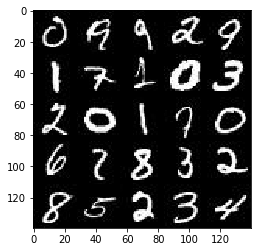

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

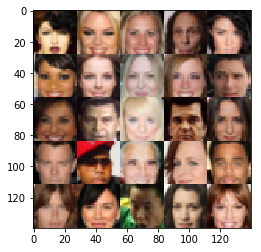

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_inputs = tf.placeholder(tf.float32, 
                                 [None, image_width, image_height, image_channels], 
                                 'real_inputs')
    tensor_z = tf.placeholder(tf.float32, [None, z_dim], 'tensor_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    
    return (real_inputs, tensor_z, learning_rate)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    
    alpha = 0.2 
    
    with tf.variable_scope('discriminator', reuse=reuse):
        
        # print (images.shape)
        # Input layer is 28x28x3
        conv1 = tf.layers.conv2d(images, 64, 5, 2, 'same')
        relu1 = tf.maximum(alpha * conv1, conv1)
        # print (relu1.shape)
        # 14x14x64   
        
        conv2 = tf.layers.conv2d(relu1, 128, 5, 2, 'same')
        bnrm2 = tf.layers.batch_normalization(conv2, training=True)
        relu2 = tf.maximum(alpha * bnrm2, bnrm2)
        # print (relu2.shape)
        # 7x7x128
        
        conv3 = tf.layers.conv2d(relu2, 256, 5, 2, 'same')
        bnrm3 = tf.layers.batch_normalization(conv3, training=True)
        relu3 = tf.maximum(alpha * bnrm3, bnrm3)
        # print (relu3.shape)
        # 4x4x256
        
        conv4 = tf.layers.conv2d(relu2, 512, 5, 2, 'same')
        bnrm4 = tf.layers.batch_normalization(conv4, training=True)
        relu4 = tf.maximum(alpha * bnrm4, bnrm4)
        # print (relu3.shape)
        # 2x2x512

        # Flatten it
        flat = tf.reshape(relu3, (-1, 2*2*512))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
         
    return (out, logits)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    alpha = 0.2 
    
    with tf.variable_scope('generator', reuse=not(is_train)):
        
        # First fully connected layer
        conv1 = tf.layers.dense(z, 7*7*512)
        # Reshape it to start the convolutional stack
        conv1 = tf.reshape(conv1, (-1, 7, 7, 512))
        conv1 = tf.layers.batch_normalization(conv1, training=is_train)
        conv1 = tf.maximum(alpha * conv1, conv1)
        # print (conv1.shape)
        # 7x7x512 now
        
        conv2 = tf.layers.conv2d_transpose(conv1, 256, 5, 2, 'same')
        conv2 = tf.layers.batch_normalization(conv2, training=is_train)
        conv2 = tf.maximum(alpha * conv2, conv2)
        # print (conv2.shape)
        # 14x14x256 now
        
        conv3 = tf.layers.conv2d_transpose(conv2, 128, 5, 2, 'same')
        conv3 = tf.layers.batch_normalization(conv3, training=is_train)
        conv3 = tf.maximum(alpha * conv3, conv3)
        # print (conv3.shape)
        # 28x28x128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(conv3, out_channel_dim, 5, 1, 'same')
        # print (logits.shape)
        # 28x28x5 now
        
        out = tf.tanh(logits)
        
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    smoothing = 0.9
    
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                labels=tf.ones_like(d_model_real) * smoothing))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                labels=tf.zeros_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake

    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    return (d_loss, g_loss)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, [n_images, z_dim])

    samples = sess.run(generator(input_z, out_channel_dim, False),
                       feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
visualise = {'d_loss':[], 'g_loss':[]}

def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """

    _, image_width, image_height, image_channels = data_shape
    
    input_real, input_z, learning_r = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_r, beta1) 
    
    steps = 0  
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images *= 2
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images,
                                                     input_z: batch_z,
                                                     learning_r: learning_rate})
                _ = sess.run(g_train_opt, feed_dict={input_z: batch_z,
                                                     input_real: batch_images,
                                                     learning_r: learning_rate})

                # print output every 10 epoch. 
                if steps % 10 == 0:      
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i + 1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                    visualise['d_loss'].append(train_loss_d)
                    visualise['g_loss'].append(train_loss_g)
                
                # show image every 10 print results. 
                if steps % 100 == 0:  
                    show_generator_output(sess, 25, input_z, image_channels, data_image_mode)
    

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.3553... Generator Loss: 7.2875
Epoch 1/2... Discriminator Loss: 0.6420... Generator Loss: 6.9323
Epoch 1/2... Discriminator Loss: 0.7147... Generator Loss: 4.0114
Epoch 1/2... Discriminator Loss: 0.6412... Generator Loss: 2.1728
Epoch 1/2... Discriminator Loss: 0.5375... Generator Loss: 2.7583
Epoch 1/2... Discriminator Loss: 1.0485... Generator Loss: 0.9194
Epoch 1/2... Discriminator Loss: 1.0336... Generator Loss: 2.2011
Epoch 1/2... Discriminator Loss: 1.4699... Generator Loss: 0.6017
Epoch 1/2... Discriminator Loss: 0.7494... Generator Loss: 2.2781
Epoch 1/2... Discriminator Loss: 1.1231... Generator Loss: 1.2879


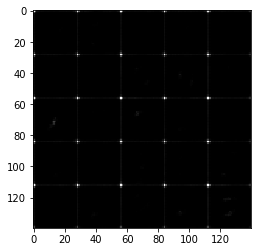

Epoch 1/2... Discriminator Loss: 1.0840... Generator Loss: 1.0007
Epoch 1/2... Discriminator Loss: 1.4357... Generator Loss: 0.4839
Epoch 1/2... Discriminator Loss: 1.2467... Generator Loss: 0.8603
Epoch 1/2... Discriminator Loss: 1.0283... Generator Loss: 1.8716
Epoch 1/2... Discriminator Loss: 1.3584... Generator Loss: 0.6539
Epoch 1/2... Discriminator Loss: 1.2507... Generator Loss: 0.8204
Epoch 1/2... Discriminator Loss: 0.9267... Generator Loss: 1.8603
Epoch 1/2... Discriminator Loss: 1.6719... Generator Loss: 1.2468
Epoch 1/2... Discriminator Loss: 1.6187... Generator Loss: 2.1096
Epoch 1/2... Discriminator Loss: 0.9664... Generator Loss: 1.3163


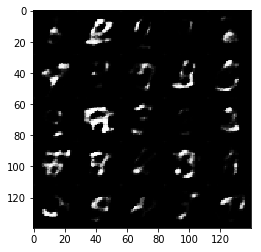

Epoch 1/2... Discriminator Loss: 1.3391... Generator Loss: 0.6190
Epoch 1/2... Discriminator Loss: 1.2365... Generator Loss: 0.7513
Epoch 1/2... Discriminator Loss: 1.2548... Generator Loss: 0.7151
Epoch 1/2... Discriminator Loss: 1.3038... Generator Loss: 1.4828
Epoch 1/2... Discriminator Loss: 1.3754... Generator Loss: 1.9326
Epoch 1/2... Discriminator Loss: 1.2773... Generator Loss: 0.8353
Epoch 1/2... Discriminator Loss: 1.2927... Generator Loss: 0.7120
Epoch 1/2... Discriminator Loss: 1.3738... Generator Loss: 1.1762
Epoch 1/2... Discriminator Loss: 1.1951... Generator Loss: 0.8213
Epoch 1/2... Discriminator Loss: 1.4652... Generator Loss: 0.6407


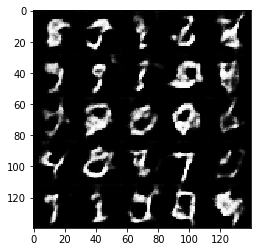

Epoch 1/2... Discriminator Loss: 1.1099... Generator Loss: 1.2073
Epoch 1/2... Discriminator Loss: 1.1806... Generator Loss: 0.9363
Epoch 1/2... Discriminator Loss: 1.3174... Generator Loss: 0.7968
Epoch 1/2... Discriminator Loss: 1.2736... Generator Loss: 1.0982
Epoch 1/2... Discriminator Loss: 1.3646... Generator Loss: 0.7390
Epoch 1/2... Discriminator Loss: 1.2453... Generator Loss: 1.2953
Epoch 1/2... Discriminator Loss: 1.1122... Generator Loss: 0.9650
Epoch 1/2... Discriminator Loss: 1.3153... Generator Loss: 0.7753
Epoch 1/2... Discriminator Loss: 1.1968... Generator Loss: 1.0067
Epoch 1/2... Discriminator Loss: 1.2269... Generator Loss: 0.7416


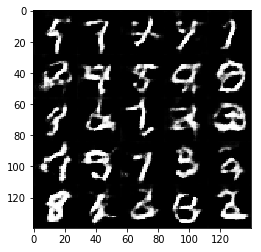

Epoch 1/2... Discriminator Loss: 1.1963... Generator Loss: 0.7486
Epoch 1/2... Discriminator Loss: 1.2336... Generator Loss: 0.9695
Epoch 1/2... Discriminator Loss: 1.2404... Generator Loss: 0.8213
Epoch 1/2... Discriminator Loss: 1.4205... Generator Loss: 0.6414
Epoch 1/2... Discriminator Loss: 1.1924... Generator Loss: 0.9391
Epoch 1/2... Discriminator Loss: 1.2663... Generator Loss: 0.8214
Epoch 1/2... Discriminator Loss: 1.1812... Generator Loss: 0.9158
Epoch 1/2... Discriminator Loss: 1.3493... Generator Loss: 0.5610
Epoch 1/2... Discriminator Loss: 1.1580... Generator Loss: 0.9180
Epoch 1/2... Discriminator Loss: 1.2366... Generator Loss: 0.7768


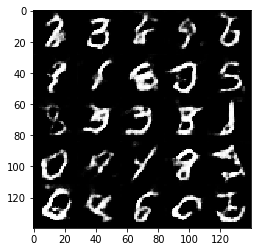

Epoch 1/2... Discriminator Loss: 1.1164... Generator Loss: 1.3129
Epoch 1/2... Discriminator Loss: 1.2335... Generator Loss: 1.1357
Epoch 1/2... Discriminator Loss: 1.1614... Generator Loss: 0.8724
Epoch 1/2... Discriminator Loss: 1.3021... Generator Loss: 0.6689
Epoch 1/2... Discriminator Loss: 1.0198... Generator Loss: 1.0457
Epoch 1/2... Discriminator Loss: 1.2286... Generator Loss: 1.3424
Epoch 1/2... Discriminator Loss: 1.1996... Generator Loss: 0.7714
Epoch 1/2... Discriminator Loss: 1.2868... Generator Loss: 0.6693
Epoch 1/2... Discriminator Loss: 1.0734... Generator Loss: 0.9931
Epoch 1/2... Discriminator Loss: 1.2822... Generator Loss: 0.7108


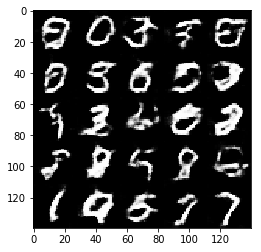

Epoch 1/2... Discriminator Loss: 1.0947... Generator Loss: 0.9179
Epoch 1/2... Discriminator Loss: 1.2504... Generator Loss: 0.9162
Epoch 1/2... Discriminator Loss: 1.1770... Generator Loss: 0.8096
Epoch 1/2... Discriminator Loss: 1.1770... Generator Loss: 0.7749
Epoch 1/2... Discriminator Loss: 1.5205... Generator Loss: 0.4543
Epoch 1/2... Discriminator Loss: 1.1741... Generator Loss: 0.9801
Epoch 1/2... Discriminator Loss: 1.1250... Generator Loss: 1.1838
Epoch 1/2... Discriminator Loss: 1.1786... Generator Loss: 0.7714
Epoch 1/2... Discriminator Loss: 1.1536... Generator Loss: 1.0695
Epoch 1/2... Discriminator Loss: 1.4102... Generator Loss: 0.4977


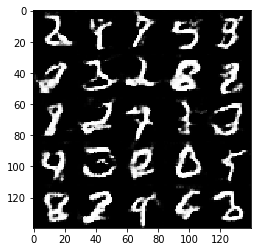

Epoch 1/2... Discriminator Loss: 1.3739... Generator Loss: 1.2798
Epoch 1/2... Discriminator Loss: 1.0741... Generator Loss: 1.0356
Epoch 1/2... Discriminator Loss: 1.1173... Generator Loss: 1.3394
Epoch 1/2... Discriminator Loss: 1.2358... Generator Loss: 1.6151
Epoch 1/2... Discriminator Loss: 1.2302... Generator Loss: 0.8827
Epoch 1/2... Discriminator Loss: 1.2037... Generator Loss: 0.7859
Epoch 1/2... Discriminator Loss: 1.2026... Generator Loss: 0.7033
Epoch 1/2... Discriminator Loss: 1.1466... Generator Loss: 0.9067
Epoch 1/2... Discriminator Loss: 1.5961... Generator Loss: 2.3297
Epoch 1/2... Discriminator Loss: 1.2044... Generator Loss: 1.0347


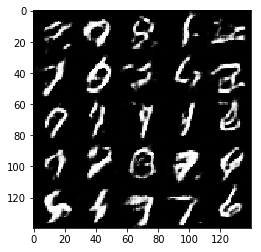

Epoch 1/2... Discriminator Loss: 1.2680... Generator Loss: 0.8061
Epoch 1/2... Discriminator Loss: 0.9687... Generator Loss: 1.3825
Epoch 1/2... Discriminator Loss: 1.2097... Generator Loss: 0.6730
Epoch 1/2... Discriminator Loss: 1.1511... Generator Loss: 0.9138
Epoch 1/2... Discriminator Loss: 1.2646... Generator Loss: 0.9657
Epoch 1/2... Discriminator Loss: 1.1103... Generator Loss: 1.0247
Epoch 1/2... Discriminator Loss: 1.1013... Generator Loss: 1.2149
Epoch 1/2... Discriminator Loss: 1.3811... Generator Loss: 0.5528
Epoch 1/2... Discriminator Loss: 1.2525... Generator Loss: 0.6976
Epoch 1/2... Discriminator Loss: 1.3195... Generator Loss: 0.5992


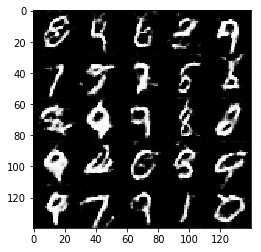

Epoch 1/2... Discriminator Loss: 1.2561... Generator Loss: 0.7395
Epoch 1/2... Discriminator Loss: 1.4475... Generator Loss: 0.4938
Epoch 1/2... Discriminator Loss: 1.2785... Generator Loss: 0.6095
Epoch 1/2... Discriminator Loss: 1.1697... Generator Loss: 0.6802
Epoch 1/2... Discriminator Loss: 0.9275... Generator Loss: 1.0527
Epoch 1/2... Discriminator Loss: 1.1692... Generator Loss: 1.2331
Epoch 1/2... Discriminator Loss: 1.4252... Generator Loss: 0.5157
Epoch 1/2... Discriminator Loss: 1.0721... Generator Loss: 1.1744
Epoch 1/2... Discriminator Loss: 1.1059... Generator Loss: 0.7710
Epoch 1/2... Discriminator Loss: 1.2183... Generator Loss: 1.2765


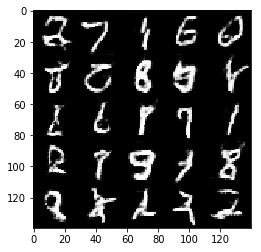

Epoch 1/2... Discriminator Loss: 1.0984... Generator Loss: 0.9571
Epoch 1/2... Discriminator Loss: 1.2295... Generator Loss: 0.6722
Epoch 1/2... Discriminator Loss: 1.4422... Generator Loss: 0.6092
Epoch 1/2... Discriminator Loss: 1.5046... Generator Loss: 0.4330
Epoch 1/2... Discriminator Loss: 1.0149... Generator Loss: 1.0627
Epoch 1/2... Discriminator Loss: 0.9443... Generator Loss: 1.1509
Epoch 1/2... Discriminator Loss: 1.1108... Generator Loss: 0.8822
Epoch 1/2... Discriminator Loss: 1.3072... Generator Loss: 0.5728
Epoch 1/2... Discriminator Loss: 1.1485... Generator Loss: 1.8381
Epoch 1/2... Discriminator Loss: 0.9862... Generator Loss: 1.5589


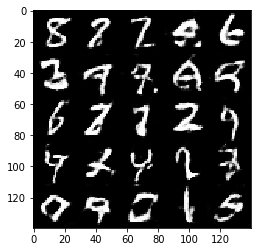

Epoch 1/2... Discriminator Loss: 1.1158... Generator Loss: 1.0485
Epoch 1/2... Discriminator Loss: 1.1167... Generator Loss: 1.5284
Epoch 1/2... Discriminator Loss: 0.9146... Generator Loss: 1.0409
Epoch 1/2... Discriminator Loss: 1.1067... Generator Loss: 0.7326
Epoch 1/2... Discriminator Loss: 2.0677... Generator Loss: 0.3074
Epoch 1/2... Discriminator Loss: 0.8734... Generator Loss: 1.4062
Epoch 1/2... Discriminator Loss: 1.2386... Generator Loss: 0.6780
Epoch 1/2... Discriminator Loss: 1.1364... Generator Loss: 0.7994
Epoch 1/2... Discriminator Loss: 1.0770... Generator Loss: 0.8199
Epoch 1/2... Discriminator Loss: 1.2041... Generator Loss: 0.6860


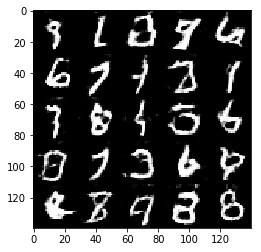

Epoch 1/2... Discriminator Loss: 1.4979... Generator Loss: 0.4815
Epoch 1/2... Discriminator Loss: 1.3465... Generator Loss: 0.5295
Epoch 1/2... Discriminator Loss: 1.1920... Generator Loss: 0.6682
Epoch 1/2... Discriminator Loss: 1.1513... Generator Loss: 2.0771
Epoch 1/2... Discriminator Loss: 1.1504... Generator Loss: 0.6836
Epoch 1/2... Discriminator Loss: 1.0189... Generator Loss: 0.8691
Epoch 1/2... Discriminator Loss: 1.0886... Generator Loss: 0.9633
Epoch 1/2... Discriminator Loss: 0.9937... Generator Loss: 0.8960
Epoch 1/2... Discriminator Loss: 0.9352... Generator Loss: 1.0335
Epoch 1/2... Discriminator Loss: 1.0401... Generator Loss: 1.6569


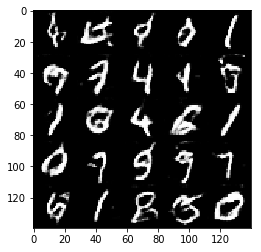

Epoch 1/2... Discriminator Loss: 1.0204... Generator Loss: 1.1277
Epoch 1/2... Discriminator Loss: 0.9368... Generator Loss: 1.4906
Epoch 1/2... Discriminator Loss: 0.9101... Generator Loss: 1.1352
Epoch 1/2... Discriminator Loss: 0.8289... Generator Loss: 1.3061
Epoch 1/2... Discriminator Loss: 0.9484... Generator Loss: 0.9746
Epoch 1/2... Discriminator Loss: 1.1964... Generator Loss: 0.7772
Epoch 1/2... Discriminator Loss: 1.1502... Generator Loss: 0.8155
Epoch 1/2... Discriminator Loss: 1.2506... Generator Loss: 0.6329
Epoch 1/2... Discriminator Loss: 1.0610... Generator Loss: 0.8838
Epoch 1/2... Discriminator Loss: 1.1574... Generator Loss: 0.6909


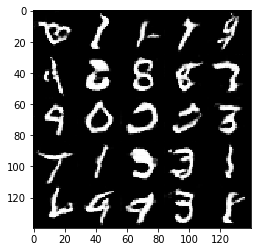

Epoch 1/2... Discriminator Loss: 1.5646... Generator Loss: 0.4570
Epoch 1/2... Discriminator Loss: 0.9429... Generator Loss: 1.2027
Epoch 1/2... Discriminator Loss: 0.9908... Generator Loss: 0.9478
Epoch 1/2... Discriminator Loss: 1.2265... Generator Loss: 0.6358
Epoch 1/2... Discriminator Loss: 1.1137... Generator Loss: 0.8153
Epoch 1/2... Discriminator Loss: 0.9287... Generator Loss: 1.2546
Epoch 1/2... Discriminator Loss: 1.4975... Generator Loss: 2.3520
Epoch 1/2... Discriminator Loss: 1.1239... Generator Loss: 0.7347
Epoch 1/2... Discriminator Loss: 0.9067... Generator Loss: 1.0449
Epoch 1/2... Discriminator Loss: 1.0738... Generator Loss: 0.8100


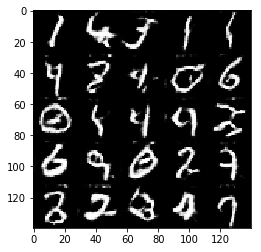

Epoch 1/2... Discriminator Loss: 1.3513... Generator Loss: 0.5558
Epoch 1/2... Discriminator Loss: 0.9022... Generator Loss: 1.3921
Epoch 1/2... Discriminator Loss: 1.0947... Generator Loss: 0.8021
Epoch 1/2... Discriminator Loss: 0.8034... Generator Loss: 1.6876
Epoch 1/2... Discriminator Loss: 0.7672... Generator Loss: 1.5532
Epoch 1/2... Discriminator Loss: 1.0188... Generator Loss: 1.5272
Epoch 1/2... Discriminator Loss: 1.2462... Generator Loss: 0.6863
Epoch 1/2... Discriminator Loss: 1.0694... Generator Loss: 0.8571
Epoch 1/2... Discriminator Loss: 1.1561... Generator Loss: 0.7671
Epoch 1/2... Discriminator Loss: 0.9159... Generator Loss: 1.2151


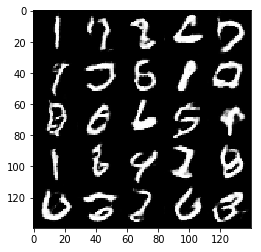

Epoch 1/2... Discriminator Loss: 1.0289... Generator Loss: 1.1799
Epoch 1/2... Discriminator Loss: 1.0037... Generator Loss: 0.8747
Epoch 1/2... Discriminator Loss: 0.7292... Generator Loss: 1.4877
Epoch 1/2... Discriminator Loss: 1.1606... Generator Loss: 0.7276
Epoch 1/2... Discriminator Loss: 0.9269... Generator Loss: 1.1282
Epoch 1/2... Discriminator Loss: 0.7980... Generator Loss: 1.2490
Epoch 1/2... Discriminator Loss: 0.8516... Generator Loss: 1.1083
Epoch 1/2... Discriminator Loss: 0.9336... Generator Loss: 1.0149
Epoch 1/2... Discriminator Loss: 1.0444... Generator Loss: 1.3138
Epoch 1/2... Discriminator Loss: 1.0637... Generator Loss: 0.8672


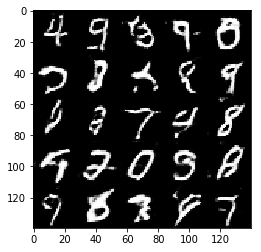

Epoch 1/2... Discriminator Loss: 1.0754... Generator Loss: 2.3969
Epoch 1/2... Discriminator Loss: 0.7640... Generator Loss: 1.3042
Epoch 1/2... Discriminator Loss: 0.8820... Generator Loss: 1.0123
Epoch 1/2... Discriminator Loss: 0.9218... Generator Loss: 1.5664
Epoch 1/2... Discriminator Loss: 1.1517... Generator Loss: 0.8048
Epoch 1/2... Discriminator Loss: 0.7240... Generator Loss: 1.5785
Epoch 1/2... Discriminator Loss: 0.9562... Generator Loss: 0.9630
Epoch 1/2... Discriminator Loss: 1.0029... Generator Loss: 0.8878
Epoch 1/2... Discriminator Loss: 0.7370... Generator Loss: 1.6209
Epoch 1/2... Discriminator Loss: 1.1731... Generator Loss: 0.7184


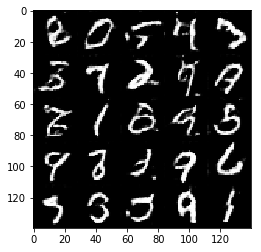

Epoch 1/2... Discriminator Loss: 1.0643... Generator Loss: 1.3874
Epoch 1/2... Discriminator Loss: 1.0948... Generator Loss: 1.4398
Epoch 1/2... Discriminator Loss: 1.0775... Generator Loss: 0.8678
Epoch 1/2... Discriminator Loss: 0.8798... Generator Loss: 1.1876
Epoch 1/2... Discriminator Loss: 0.8320... Generator Loss: 1.1998
Epoch 1/2... Discriminator Loss: 0.7950... Generator Loss: 1.8991
Epoch 1/2... Discriminator Loss: 0.9014... Generator Loss: 2.1533
Epoch 2/2... Discriminator Loss: 0.9350... Generator Loss: 2.1350
Epoch 2/2... Discriminator Loss: 1.4002... Generator Loss: 0.5521
Epoch 2/2... Discriminator Loss: 1.2065... Generator Loss: 0.6974


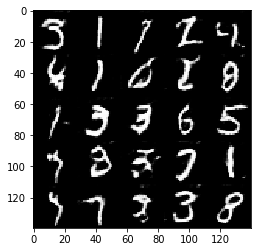

Epoch 2/2... Discriminator Loss: 1.1736... Generator Loss: 0.7253
Epoch 2/2... Discriminator Loss: 0.8246... Generator Loss: 1.1207
Epoch 2/2... Discriminator Loss: 1.1517... Generator Loss: 0.7270
Epoch 2/2... Discriminator Loss: 0.9670... Generator Loss: 0.9465
Epoch 2/2... Discriminator Loss: 0.7939... Generator Loss: 1.2575
Epoch 2/2... Discriminator Loss: 1.0070... Generator Loss: 0.9330
Epoch 2/2... Discriminator Loss: 0.8815... Generator Loss: 1.0483
Epoch 2/2... Discriminator Loss: 1.0800... Generator Loss: 0.8084
Epoch 2/2... Discriminator Loss: 1.0297... Generator Loss: 1.8031
Epoch 2/2... Discriminator Loss: 0.9440... Generator Loss: 1.7041


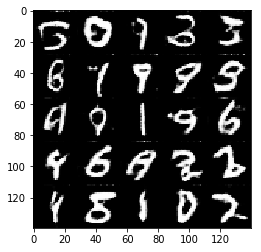

Epoch 2/2... Discriminator Loss: 0.6772... Generator Loss: 1.4742
Epoch 2/2... Discriminator Loss: 0.5419... Generator Loss: 2.0864
Epoch 2/2... Discriminator Loss: 0.6261... Generator Loss: 2.0124
Epoch 2/2... Discriminator Loss: 1.2341... Generator Loss: 0.6512
Epoch 2/2... Discriminator Loss: 1.3082... Generator Loss: 0.6409
Epoch 2/2... Discriminator Loss: 0.7165... Generator Loss: 1.8464
Epoch 2/2... Discriminator Loss: 0.8164... Generator Loss: 1.4276
Epoch 2/2... Discriminator Loss: 1.1622... Generator Loss: 0.7434
Epoch 2/2... Discriminator Loss: 0.7623... Generator Loss: 1.5870
Epoch 2/2... Discriminator Loss: 0.6644... Generator Loss: 1.6764


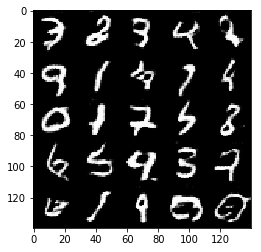

Epoch 2/2... Discriminator Loss: 0.8834... Generator Loss: 1.2055
Epoch 2/2... Discriminator Loss: 0.9271... Generator Loss: 0.9901
Epoch 2/2... Discriminator Loss: 0.8484... Generator Loss: 1.1530
Epoch 2/2... Discriminator Loss: 0.8185... Generator Loss: 1.2372
Epoch 2/2... Discriminator Loss: 1.1689... Generator Loss: 0.7915
Epoch 2/2... Discriminator Loss: 0.7302... Generator Loss: 1.8946
Epoch 2/2... Discriminator Loss: 0.6992... Generator Loss: 1.4455
Epoch 2/2... Discriminator Loss: 0.8351... Generator Loss: 1.2519
Epoch 2/2... Discriminator Loss: 0.6820... Generator Loss: 1.5316
Epoch 2/2... Discriminator Loss: 1.2645... Generator Loss: 0.6511


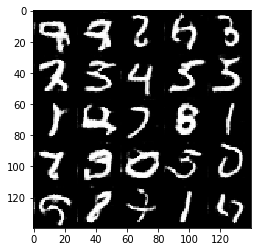

Epoch 2/2... Discriminator Loss: 0.9130... Generator Loss: 1.1394
Epoch 2/2... Discriminator Loss: 0.6486... Generator Loss: 2.1439
Epoch 2/2... Discriminator Loss: 1.0625... Generator Loss: 0.7711
Epoch 2/2... Discriminator Loss: 0.9037... Generator Loss: 1.0313
Epoch 2/2... Discriminator Loss: 0.6427... Generator Loss: 1.7557
Epoch 2/2... Discriminator Loss: 0.7124... Generator Loss: 1.3899
Epoch 2/2... Discriminator Loss: 0.7019... Generator Loss: 2.0583
Epoch 2/2... Discriminator Loss: 1.0860... Generator Loss: 0.9465
Epoch 2/2... Discriminator Loss: 1.5101... Generator Loss: 0.5156
Epoch 2/2... Discriminator Loss: 0.5961... Generator Loss: 1.8948


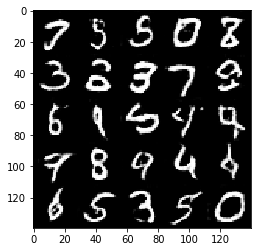

Epoch 2/2... Discriminator Loss: 0.6254... Generator Loss: 1.7900
Epoch 2/2... Discriminator Loss: 0.7738... Generator Loss: 1.3871
Epoch 2/2... Discriminator Loss: 0.7107... Generator Loss: 1.4494
Epoch 2/2... Discriminator Loss: 1.1857... Generator Loss: 0.7103
Epoch 2/2... Discriminator Loss: 0.8391... Generator Loss: 1.1380
Epoch 2/2... Discriminator Loss: 1.0417... Generator Loss: 0.8698
Epoch 2/2... Discriminator Loss: 0.9459... Generator Loss: 1.0029
Epoch 2/2... Discriminator Loss: 0.8359... Generator Loss: 1.1629
Epoch 2/2... Discriminator Loss: 0.7197... Generator Loss: 1.7891
Epoch 2/2... Discriminator Loss: 1.0109... Generator Loss: 0.9199


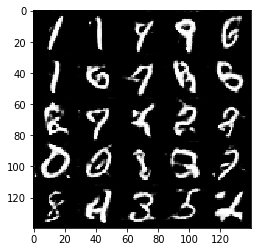

Epoch 2/2... Discriminator Loss: 0.7564... Generator Loss: 1.3013
Epoch 2/2... Discriminator Loss: 0.9215... Generator Loss: 1.0094
Epoch 2/2... Discriminator Loss: 0.5371... Generator Loss: 2.1220
Epoch 2/2... Discriminator Loss: 0.7050... Generator Loss: 1.4051
Epoch 2/2... Discriminator Loss: 0.7982... Generator Loss: 1.1694
Epoch 2/2... Discriminator Loss: 1.4135... Generator Loss: 0.5257
Epoch 2/2... Discriminator Loss: 0.9843... Generator Loss: 0.9823
Epoch 2/2... Discriminator Loss: 0.6370... Generator Loss: 1.6085
Epoch 2/2... Discriminator Loss: 1.5427... Generator Loss: 2.8093
Epoch 2/2... Discriminator Loss: 0.8963... Generator Loss: 1.1219


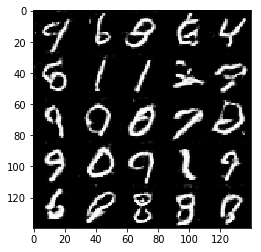

Epoch 2/2... Discriminator Loss: 0.7557... Generator Loss: 1.4921
Epoch 2/2... Discriminator Loss: 0.8132... Generator Loss: 1.5078
Epoch 2/2... Discriminator Loss: 0.7080... Generator Loss: 1.6141
Epoch 2/2... Discriminator Loss: 0.6989... Generator Loss: 1.8844
Epoch 2/2... Discriminator Loss: 1.2906... Generator Loss: 0.7056
Epoch 2/2... Discriminator Loss: 0.7025... Generator Loss: 1.5736
Epoch 2/2... Discriminator Loss: 0.7586... Generator Loss: 1.3210
Epoch 2/2... Discriminator Loss: 0.6430... Generator Loss: 1.7079
Epoch 2/2... Discriminator Loss: 0.8900... Generator Loss: 1.2245
Epoch 2/2... Discriminator Loss: 1.0699... Generator Loss: 0.9148


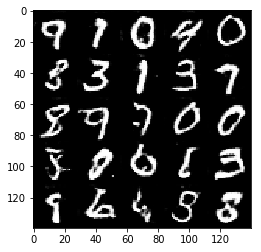

Epoch 2/2... Discriminator Loss: 0.9589... Generator Loss: 1.0624
Epoch 2/2... Discriminator Loss: 0.7278... Generator Loss: 1.5240
Epoch 2/2... Discriminator Loss: 0.7534... Generator Loss: 2.3859
Epoch 2/2... Discriminator Loss: 0.7900... Generator Loss: 1.2361
Epoch 2/2... Discriminator Loss: 0.6236... Generator Loss: 1.6046
Epoch 2/2... Discriminator Loss: 0.6205... Generator Loss: 1.6504
Epoch 2/2... Discriminator Loss: 0.6980... Generator Loss: 1.4317
Epoch 2/2... Discriminator Loss: 1.3867... Generator Loss: 0.6682
Epoch 2/2... Discriminator Loss: 0.6818... Generator Loss: 1.9476
Epoch 2/2... Discriminator Loss: 0.7509... Generator Loss: 1.6161


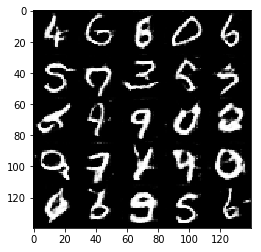

Epoch 2/2... Discriminator Loss: 1.0029... Generator Loss: 1.1186
Epoch 2/2... Discriminator Loss: 0.7362... Generator Loss: 1.3845
Epoch 2/2... Discriminator Loss: 0.8559... Generator Loss: 1.2485
Epoch 2/2... Discriminator Loss: 0.8146... Generator Loss: 1.8381
Epoch 2/2... Discriminator Loss: 0.5915... Generator Loss: 1.7777
Epoch 2/2... Discriminator Loss: 0.7224... Generator Loss: 1.3513
Epoch 2/2... Discriminator Loss: 0.5855... Generator Loss: 1.9705
Epoch 2/2... Discriminator Loss: 0.9472... Generator Loss: 1.0473
Epoch 2/2... Discriminator Loss: 1.9817... Generator Loss: 0.3510
Epoch 2/2... Discriminator Loss: 0.7965... Generator Loss: 1.1831


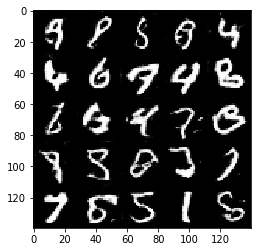

Epoch 2/2... Discriminator Loss: 0.8689... Generator Loss: 1.8803
Epoch 2/2... Discriminator Loss: 0.7457... Generator Loss: 1.7798
Epoch 2/2... Discriminator Loss: 0.6939... Generator Loss: 1.5454
Epoch 2/2... Discriminator Loss: 1.0520... Generator Loss: 1.0475
Epoch 2/2... Discriminator Loss: 0.8013... Generator Loss: 1.7391
Epoch 2/2... Discriminator Loss: 1.4134... Generator Loss: 0.5956
Epoch 2/2... Discriminator Loss: 0.7741... Generator Loss: 1.2543
Epoch 2/2... Discriminator Loss: 0.7754... Generator Loss: 1.3561
Epoch 2/2... Discriminator Loss: 0.6566... Generator Loss: 1.6982
Epoch 2/2... Discriminator Loss: 1.4091... Generator Loss: 0.6204


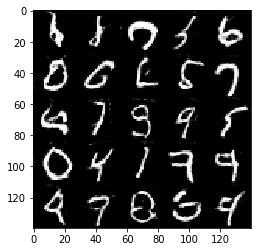

Epoch 2/2... Discriminator Loss: 0.6749... Generator Loss: 1.6219
Epoch 2/2... Discriminator Loss: 0.7646... Generator Loss: 1.3104
Epoch 2/2... Discriminator Loss: 0.7593... Generator Loss: 1.6194
Epoch 2/2... Discriminator Loss: 0.9529... Generator Loss: 0.9818
Epoch 2/2... Discriminator Loss: 0.6442... Generator Loss: 1.9006
Epoch 2/2... Discriminator Loss: 0.7193... Generator Loss: 2.6844
Epoch 2/2... Discriminator Loss: 0.6949... Generator Loss: 1.4568
Epoch 2/2... Discriminator Loss: 1.2008... Generator Loss: 0.7811
Epoch 2/2... Discriminator Loss: 0.6963... Generator Loss: 1.4711
Epoch 2/2... Discriminator Loss: 3.3638... Generator Loss: 0.1081


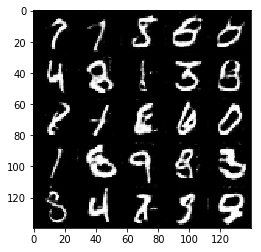

Epoch 2/2... Discriminator Loss: 0.8844... Generator Loss: 1.0892
Epoch 2/2... Discriminator Loss: 0.7363... Generator Loss: 1.4214
Epoch 2/2... Discriminator Loss: 0.7669... Generator Loss: 1.2510
Epoch 2/2... Discriminator Loss: 0.9715... Generator Loss: 1.0312
Epoch 2/2... Discriminator Loss: 0.7278... Generator Loss: 1.4607
Epoch 2/2... Discriminator Loss: 0.6220... Generator Loss: 1.5935
Epoch 2/2... Discriminator Loss: 0.8673... Generator Loss: 1.0433
Epoch 2/2... Discriminator Loss: 0.5781... Generator Loss: 1.8512
Epoch 2/2... Discriminator Loss: 1.1889... Generator Loss: 0.7172
Epoch 2/2... Discriminator Loss: 1.7096... Generator Loss: 0.5317


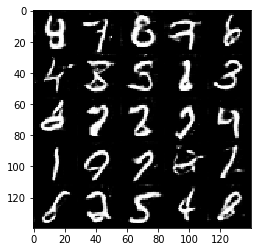

Epoch 2/2... Discriminator Loss: 0.7165... Generator Loss: 1.3063
Epoch 2/2... Discriminator Loss: 0.6587... Generator Loss: 1.5512
Epoch 2/2... Discriminator Loss: 0.6037... Generator Loss: 1.9124
Epoch 2/2... Discriminator Loss: 0.7715... Generator Loss: 1.3839
Epoch 2/2... Discriminator Loss: 1.3900... Generator Loss: 0.8109
Epoch 2/2... Discriminator Loss: 0.8543... Generator Loss: 1.0721
Epoch 2/2... Discriminator Loss: 0.5473... Generator Loss: 2.0378
Epoch 2/2... Discriminator Loss: 1.0436... Generator Loss: 0.8205
Epoch 2/2... Discriminator Loss: 1.0603... Generator Loss: 0.9070
Epoch 2/2... Discriminator Loss: 0.6754... Generator Loss: 1.5893


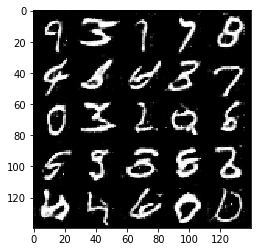

Epoch 2/2... Discriminator Loss: 0.8620... Generator Loss: 2.0333
Epoch 2/2... Discriminator Loss: 0.7499... Generator Loss: 1.3953
Epoch 2/2... Discriminator Loss: 0.8650... Generator Loss: 2.1348
Epoch 2/2... Discriminator Loss: 0.7566... Generator Loss: 1.3062
Epoch 2/2... Discriminator Loss: 1.2586... Generator Loss: 0.6928
Epoch 2/2... Discriminator Loss: 1.0518... Generator Loss: 0.9299
Epoch 2/2... Discriminator Loss: 0.5836... Generator Loss: 1.9804
Epoch 2/2... Discriminator Loss: 0.6102... Generator Loss: 3.1758
Epoch 2/2... Discriminator Loss: 0.8403... Generator Loss: 1.3634
Epoch 2/2... Discriminator Loss: 0.9819... Generator Loss: 0.9486


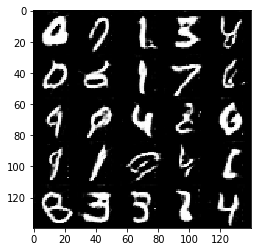

Epoch 2/2... Discriminator Loss: 1.4042... Generator Loss: 0.6199
Epoch 2/2... Discriminator Loss: 0.7048... Generator Loss: 1.8238
Epoch 2/2... Discriminator Loss: 0.6463... Generator Loss: 1.6957
Epoch 2/2... Discriminator Loss: 0.7062... Generator Loss: 1.6343
Epoch 2/2... Discriminator Loss: 0.7613... Generator Loss: 1.3346
Epoch 2/2... Discriminator Loss: 0.6779... Generator Loss: 1.7723
Epoch 2/2... Discriminator Loss: 0.5664... Generator Loss: 1.9014
Epoch 2/2... Discriminator Loss: 0.6622... Generator Loss: 1.5612
Epoch 2/2... Discriminator Loss: 0.5675... Generator Loss: 1.8089
Epoch 2/2... Discriminator Loss: 0.9144... Generator Loss: 0.9959


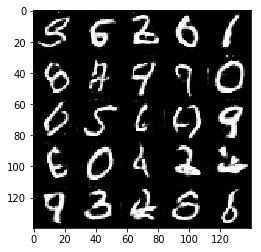

Epoch 2/2... Discriminator Loss: 0.7431... Generator Loss: 1.3924
Epoch 2/2... Discriminator Loss: 0.6803... Generator Loss: 1.5299
Epoch 2/2... Discriminator Loss: 0.6942... Generator Loss: 1.5288
Epoch 2/2... Discriminator Loss: 1.2104... Generator Loss: 4.4051
Epoch 2/2... Discriminator Loss: 0.7194... Generator Loss: 2.0939
Epoch 2/2... Discriminator Loss: 1.7783... Generator Loss: 0.5081
Epoch 2/2... Discriminator Loss: 0.7629... Generator Loss: 1.4613
Epoch 2/2... Discriminator Loss: 0.8436... Generator Loss: 1.4656
Epoch 2/2... Discriminator Loss: 1.0102... Generator Loss: 0.8696
Epoch 2/2... Discriminator Loss: 0.7923... Generator Loss: 1.1507


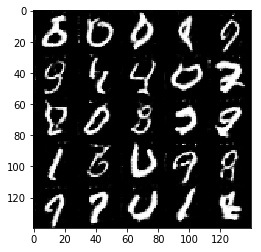

Epoch 2/2... Discriminator Loss: 1.3948... Generator Loss: 0.7323
Epoch 2/2... Discriminator Loss: 0.8686... Generator Loss: 1.4236
Epoch 2/2... Discriminator Loss: 0.8523... Generator Loss: 1.1937
Epoch 2/2... Discriminator Loss: 0.8384... Generator Loss: 1.1561
Epoch 2/2... Discriminator Loss: 0.6938... Generator Loss: 1.4671
Epoch 2/2... Discriminator Loss: 0.5966... Generator Loss: 1.7593
Epoch 2/2... Discriminator Loss: 0.7650... Generator Loss: 1.2529
Epoch 2/2... Discriminator Loss: 0.6317... Generator Loss: 1.6761
Epoch 2/2... Discriminator Loss: 0.6424... Generator Loss: 2.0067
Epoch 2/2... Discriminator Loss: 0.5799... Generator Loss: 2.1577


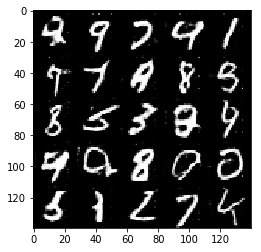

Epoch 2/2... Discriminator Loss: 0.8085... Generator Loss: 1.1883
Epoch 2/2... Discriminator Loss: 0.7927... Generator Loss: 1.3606
Epoch 2/2... Discriminator Loss: 0.6423... Generator Loss: 1.8252
Epoch 2/2... Discriminator Loss: 0.7768... Generator Loss: 1.4999
Epoch 2/2... Discriminator Loss: 0.7394... Generator Loss: 2.4279
Epoch 2/2... Discriminator Loss: 0.9249... Generator Loss: 1.0482
Epoch 2/2... Discriminator Loss: 0.8175... Generator Loss: 2.4318
Epoch 2/2... Discriminator Loss: 0.8399... Generator Loss: 1.2774
Epoch 2/2... Discriminator Loss: 0.7626... Generator Loss: 1.3538
Epoch 2/2... Discriminator Loss: 0.4115... Generator Loss: 4.0302


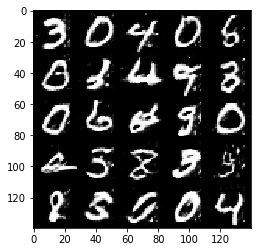

Epoch 2/2... Discriminator Loss: 0.6357... Generator Loss: 1.7088
Epoch 2/2... Discriminator Loss: 0.5952... Generator Loss: 2.1076
Epoch 2/2... Discriminator Loss: 0.6466... Generator Loss: 1.6181
Epoch 2/2... Discriminator Loss: 0.7000... Generator Loss: 2.0614
Epoch 2/2... Discriminator Loss: 0.5871... Generator Loss: 1.8395


In [12]:
batch_size = 32
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

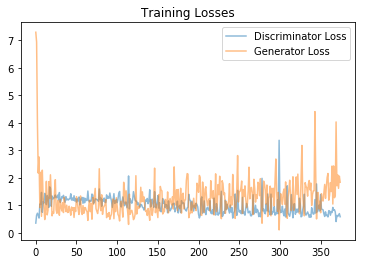

In [13]:
# visualisation

pyplot.plot(visualise['d_loss'], label='Discriminator Loss', alpha=0.5)
pyplot.plot(visualise['g_loss'], label='Generator Loss', alpha=0.5)
pyplot.legend()

pyplot.title("Training Losses")

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.3943... Generator Loss: 8.5366
Epoch 1/1... Discriminator Loss: 1.0827... Generator Loss: 17.1861
Epoch 1/1... Discriminator Loss: 1.0416... Generator Loss: 1.0589
Epoch 1/1... Discriminator Loss: 0.8569... Generator Loss: 3.7776
Epoch 1/1... Discriminator Loss: 0.4574... Generator Loss: 3.1032
Epoch 1/1... Discriminator Loss: 1.4416... Generator Loss: 3.5303
Epoch 1/1... Discriminator Loss: 0.6908... Generator Loss: 1.9176
Epoch 1/1... Discriminator Loss: 0.6617... Generator Loss: 1.5890
Epoch 1/1... Discriminator Loss: 0.9405... Generator Loss: 1.1755
Epoch 1/1... Discriminator Loss: 0.4653... Generator Loss: 3.1493


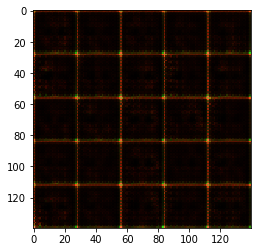

Epoch 1/1... Discriminator Loss: 0.6707... Generator Loss: 1.6281
Epoch 1/1... Discriminator Loss: 0.3780... Generator Loss: 4.7293
Epoch 1/1... Discriminator Loss: 1.6811... Generator Loss: 0.4152
Epoch 1/1... Discriminator Loss: 1.0456... Generator Loss: 1.3851
Epoch 1/1... Discriminator Loss: 0.8943... Generator Loss: 2.0811
Epoch 1/1... Discriminator Loss: 0.8998... Generator Loss: 1.1091
Epoch 1/1... Discriminator Loss: 1.1217... Generator Loss: 1.2549
Epoch 1/1... Discriminator Loss: 1.3086... Generator Loss: 0.5799
Epoch 1/1... Discriminator Loss: 1.1216... Generator Loss: 1.1773
Epoch 1/1... Discriminator Loss: 1.3412... Generator Loss: 0.8438


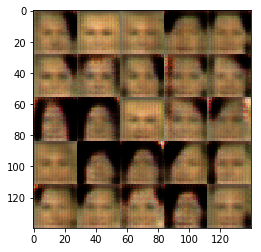

Epoch 1/1... Discriminator Loss: 0.9246... Generator Loss: 1.3865
Epoch 1/1... Discriminator Loss: 1.0238... Generator Loss: 1.4631
Epoch 1/1... Discriminator Loss: 1.1245... Generator Loss: 1.0376
Epoch 1/1... Discriminator Loss: 1.5550... Generator Loss: 0.4937
Epoch 1/1... Discriminator Loss: 0.6837... Generator Loss: 1.7043
Epoch 1/1... Discriminator Loss: 0.7680... Generator Loss: 1.8644
Epoch 1/1... Discriminator Loss: 0.9090... Generator Loss: 1.4960
Epoch 1/1... Discriminator Loss: 0.8444... Generator Loss: 1.4845
Epoch 1/1... Discriminator Loss: 1.2736... Generator Loss: 0.6390
Epoch 1/1... Discriminator Loss: 1.4205... Generator Loss: 0.5398


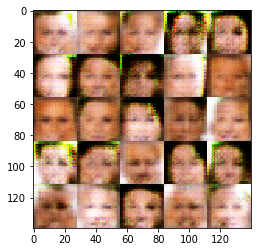

Epoch 1/1... Discriminator Loss: 1.1617... Generator Loss: 1.4669
Epoch 1/1... Discriminator Loss: 1.6418... Generator Loss: 2.9932
Epoch 1/1... Discriminator Loss: 1.1169... Generator Loss: 1.2883
Epoch 1/1... Discriminator Loss: 1.1720... Generator Loss: 0.8628
Epoch 1/1... Discriminator Loss: 1.3883... Generator Loss: 0.5216
Epoch 1/1... Discriminator Loss: 1.2462... Generator Loss: 1.0694
Epoch 1/1... Discriminator Loss: 1.1052... Generator Loss: 1.3841
Epoch 1/1... Discriminator Loss: 0.9434... Generator Loss: 1.5022
Epoch 1/1... Discriminator Loss: 0.9624... Generator Loss: 1.6398
Epoch 1/1... Discriminator Loss: 0.9750... Generator Loss: 1.8404


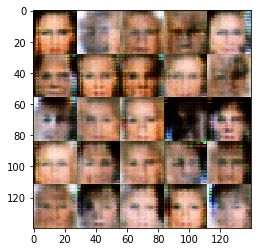

Epoch 1/1... Discriminator Loss: 1.6621... Generator Loss: 0.3628
Epoch 1/1... Discriminator Loss: 1.1959... Generator Loss: 1.0564
Epoch 1/1... Discriminator Loss: 1.7421... Generator Loss: 0.3203
Epoch 1/1... Discriminator Loss: 1.1745... Generator Loss: 0.6895
Epoch 1/1... Discriminator Loss: 1.2440... Generator Loss: 0.9457
Epoch 1/1... Discriminator Loss: 1.1956... Generator Loss: 1.0561
Epoch 1/1... Discriminator Loss: 0.6699... Generator Loss: 2.1216
Epoch 1/1... Discriminator Loss: 1.9399... Generator Loss: 0.2914
Epoch 1/1... Discriminator Loss: 0.9774... Generator Loss: 1.0149
Epoch 1/1... Discriminator Loss: 1.1141... Generator Loss: 0.7693


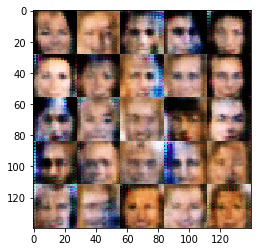

Epoch 1/1... Discriminator Loss: 1.2788... Generator Loss: 0.7579
Epoch 1/1... Discriminator Loss: 1.1793... Generator Loss: 1.2889
Epoch 1/1... Discriminator Loss: 0.9717... Generator Loss: 0.9743
Epoch 1/1... Discriminator Loss: 1.0775... Generator Loss: 1.3062
Epoch 1/1... Discriminator Loss: 1.1897... Generator Loss: 0.9416
Epoch 1/1... Discriminator Loss: 0.8661... Generator Loss: 1.3042
Epoch 1/1... Discriminator Loss: 1.1207... Generator Loss: 0.9679
Epoch 1/1... Discriminator Loss: 0.9231... Generator Loss: 1.0245
Epoch 1/1... Discriminator Loss: 1.5851... Generator Loss: 0.6672
Epoch 1/1... Discriminator Loss: 0.7964... Generator Loss: 1.3668


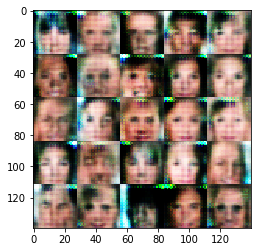

Epoch 1/1... Discriminator Loss: 1.4180... Generator Loss: 0.5433
Epoch 1/1... Discriminator Loss: 1.1662... Generator Loss: 1.0912
Epoch 1/1... Discriminator Loss: 1.9529... Generator Loss: 0.2562
Epoch 1/1... Discriminator Loss: 1.3520... Generator Loss: 0.5310
Epoch 1/1... Discriminator Loss: 1.2191... Generator Loss: 1.0821
Epoch 1/1... Discriminator Loss: 0.9444... Generator Loss: 1.2049
Epoch 1/1... Discriminator Loss: 1.2830... Generator Loss: 0.9550
Epoch 1/1... Discriminator Loss: 1.5031... Generator Loss: 0.4483
Epoch 1/1... Discriminator Loss: 1.0667... Generator Loss: 1.4847
Epoch 1/1... Discriminator Loss: 1.6170... Generator Loss: 0.3878


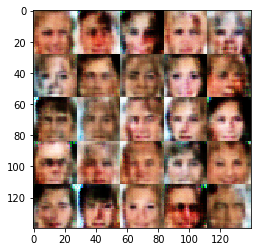

Epoch 1/1... Discriminator Loss: 0.9961... Generator Loss: 0.8901
Epoch 1/1... Discriminator Loss: 1.0143... Generator Loss: 1.4896
Epoch 1/1... Discriminator Loss: 0.8467... Generator Loss: 1.4855
Epoch 1/1... Discriminator Loss: 1.0012... Generator Loss: 1.1026
Epoch 1/1... Discriminator Loss: 1.2114... Generator Loss: 0.6762
Epoch 1/1... Discriminator Loss: 1.8660... Generator Loss: 1.9902
Epoch 1/1... Discriminator Loss: 1.0976... Generator Loss: 0.8572
Epoch 1/1... Discriminator Loss: 1.2981... Generator Loss: 0.7194
Epoch 1/1... Discriminator Loss: 1.2238... Generator Loss: 1.3963
Epoch 1/1... Discriminator Loss: 1.0397... Generator Loss: 1.0795


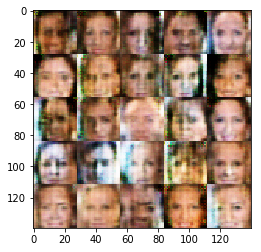

Epoch 1/1... Discriminator Loss: 1.4786... Generator Loss: 0.8294
Epoch 1/1... Discriminator Loss: 1.0924... Generator Loss: 1.1030
Epoch 1/1... Discriminator Loss: 1.4234... Generator Loss: 0.5798
Epoch 1/1... Discriminator Loss: 1.5766... Generator Loss: 0.4042
Epoch 1/1... Discriminator Loss: 1.0915... Generator Loss: 0.7622
Epoch 1/1... Discriminator Loss: 1.2127... Generator Loss: 0.9066
Epoch 1/1... Discriminator Loss: 1.3051... Generator Loss: 0.6167
Epoch 1/1... Discriminator Loss: 1.3210... Generator Loss: 0.6055
Epoch 1/1... Discriminator Loss: 1.3349... Generator Loss: 0.5799
Epoch 1/1... Discriminator Loss: 1.3354... Generator Loss: 0.8578


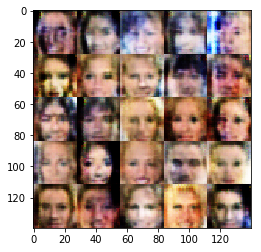

Epoch 1/1... Discriminator Loss: 2.8901... Generator Loss: 3.1797
Epoch 1/1... Discriminator Loss: 1.4112... Generator Loss: 0.7331
Epoch 1/1... Discriminator Loss: 1.1087... Generator Loss: 1.0966
Epoch 1/1... Discriminator Loss: 0.7946... Generator Loss: 1.3304
Epoch 1/1... Discriminator Loss: 0.8148... Generator Loss: 1.4590
Epoch 1/1... Discriminator Loss: 1.4931... Generator Loss: 0.5484
Epoch 1/1... Discriminator Loss: 0.6603... Generator Loss: 1.6106
Epoch 1/1... Discriminator Loss: 0.5143... Generator Loss: 2.7007
Epoch 1/1... Discriminator Loss: 1.0056... Generator Loss: 1.4294
Epoch 1/1... Discriminator Loss: 0.6663... Generator Loss: 1.6417


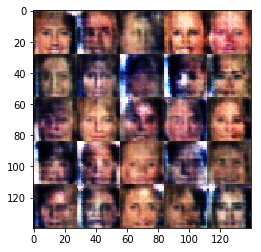

Epoch 1/1... Discriminator Loss: 0.9179... Generator Loss: 1.2550
Epoch 1/1... Discriminator Loss: 0.9074... Generator Loss: 1.7783
Epoch 1/1... Discriminator Loss: 0.7546... Generator Loss: 2.0300
Epoch 1/1... Discriminator Loss: 0.7684... Generator Loss: 1.3463
Epoch 1/1... Discriminator Loss: 0.4798... Generator Loss: 2.5520
Epoch 1/1... Discriminator Loss: 1.0251... Generator Loss: 1.0017
Epoch 1/1... Discriminator Loss: 1.1127... Generator Loss: 0.9601
Epoch 1/1... Discriminator Loss: 1.2427... Generator Loss: 0.6478
Epoch 1/1... Discriminator Loss: 1.1932... Generator Loss: 0.7600
Epoch 1/1... Discriminator Loss: 1.3149... Generator Loss: 0.6672


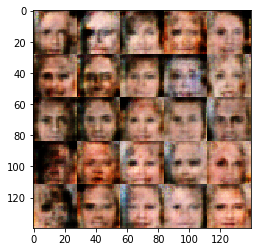

Epoch 1/1... Discriminator Loss: 1.6390... Generator Loss: 0.3718
Epoch 1/1... Discriminator Loss: 1.3828... Generator Loss: 0.6314
Epoch 1/1... Discriminator Loss: 1.3533... Generator Loss: 0.7194
Epoch 1/1... Discriminator Loss: 1.2222... Generator Loss: 0.8608
Epoch 1/1... Discriminator Loss: 1.2617... Generator Loss: 0.8649
Epoch 1/1... Discriminator Loss: 1.2846... Generator Loss: 0.7017
Epoch 1/1... Discriminator Loss: 2.2652... Generator Loss: 0.1793
Epoch 1/1... Discriminator Loss: 1.3154... Generator Loss: 0.7603
Epoch 1/1... Discriminator Loss: 1.3157... Generator Loss: 0.6622
Epoch 1/1... Discriminator Loss: 1.0956... Generator Loss: 0.7653


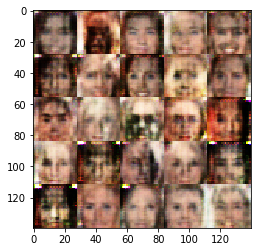

Epoch 1/1... Discriminator Loss: 1.5589... Generator Loss: 0.5090
Epoch 1/1... Discriminator Loss: 1.1028... Generator Loss: 0.9840
Epoch 1/1... Discriminator Loss: 1.4832... Generator Loss: 2.0523
Epoch 1/1... Discriminator Loss: 1.1560... Generator Loss: 1.1296
Epoch 1/1... Discriminator Loss: 1.1299... Generator Loss: 0.8160
Epoch 1/1... Discriminator Loss: 1.5071... Generator Loss: 0.8053
Epoch 1/1... Discriminator Loss: 1.3595... Generator Loss: 0.9031
Epoch 1/1... Discriminator Loss: 1.1547... Generator Loss: 0.9922
Epoch 1/1... Discriminator Loss: 1.3766... Generator Loss: 0.7890
Epoch 1/1... Discriminator Loss: 1.2361... Generator Loss: 0.7555


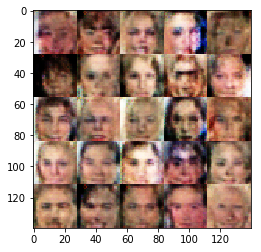

Epoch 1/1... Discriminator Loss: 1.4108... Generator Loss: 0.5306
Epoch 1/1... Discriminator Loss: 1.2995... Generator Loss: 0.6811
Epoch 1/1... Discriminator Loss: 1.4370... Generator Loss: 0.5477
Epoch 1/1... Discriminator Loss: 1.1830... Generator Loss: 0.7342
Epoch 1/1... Discriminator Loss: 1.2500... Generator Loss: 1.4497
Epoch 1/1... Discriminator Loss: 1.6953... Generator Loss: 0.3716
Epoch 1/1... Discriminator Loss: 1.0583... Generator Loss: 0.9862
Epoch 1/1... Discriminator Loss: 1.3263... Generator Loss: 0.7875
Epoch 1/1... Discriminator Loss: 1.3384... Generator Loss: 0.7827
Epoch 1/1... Discriminator Loss: 1.0846... Generator Loss: 1.0219


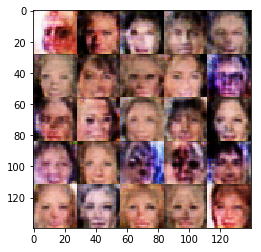

Epoch 1/1... Discriminator Loss: 1.4692... Generator Loss: 0.5956
Epoch 1/1... Discriminator Loss: 1.2265... Generator Loss: 0.7719
Epoch 1/1... Discriminator Loss: 1.3438... Generator Loss: 0.6485
Epoch 1/1... Discriminator Loss: 1.3874... Generator Loss: 0.5520
Epoch 1/1... Discriminator Loss: 1.2658... Generator Loss: 0.6866
Epoch 1/1... Discriminator Loss: 1.3007... Generator Loss: 0.6039
Epoch 1/1... Discriminator Loss: 1.2925... Generator Loss: 0.7481
Epoch 1/1... Discriminator Loss: 0.9449... Generator Loss: 1.2362
Epoch 1/1... Discriminator Loss: 1.3204... Generator Loss: 1.0272
Epoch 1/1... Discriminator Loss: 1.0396... Generator Loss: 0.8552


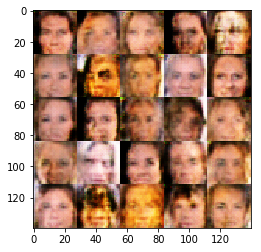

Epoch 1/1... Discriminator Loss: 1.3616... Generator Loss: 0.7208
Epoch 1/1... Discriminator Loss: 1.3506... Generator Loss: 1.2010
Epoch 1/1... Discriminator Loss: 1.2347... Generator Loss: 0.8271
Epoch 1/1... Discriminator Loss: 1.1003... Generator Loss: 1.0480
Epoch 1/1... Discriminator Loss: 1.1417... Generator Loss: 1.1812
Epoch 1/1... Discriminator Loss: 1.1822... Generator Loss: 0.9668
Epoch 1/1... Discriminator Loss: 1.2937... Generator Loss: 0.6886
Epoch 1/1... Discriminator Loss: 0.8515... Generator Loss: 1.2418
Epoch 1/1... Discriminator Loss: 1.2038... Generator Loss: 0.8246
Epoch 1/1... Discriminator Loss: 1.3569... Generator Loss: 0.7849


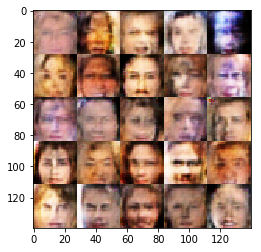

Epoch 1/1... Discriminator Loss: 1.2545... Generator Loss: 0.6504
Epoch 1/1... Discriminator Loss: 1.2486... Generator Loss: 0.7307
Epoch 1/1... Discriminator Loss: 1.7277... Generator Loss: 1.0922
Epoch 1/1... Discriminator Loss: 1.1424... Generator Loss: 0.8431
Epoch 1/1... Discriminator Loss: 1.2743... Generator Loss: 0.6566
Epoch 1/1... Discriminator Loss: 1.3228... Generator Loss: 0.7847
Epoch 1/1... Discriminator Loss: 1.0090... Generator Loss: 0.9494
Epoch 1/1... Discriminator Loss: 1.0899... Generator Loss: 1.0217
Epoch 1/1... Discriminator Loss: 1.1424... Generator Loss: 0.7657
Epoch 1/1... Discriminator Loss: 1.4098... Generator Loss: 0.6812


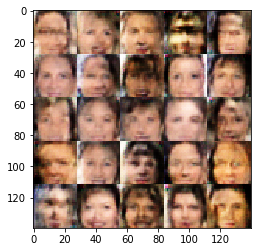

Epoch 1/1... Discriminator Loss: 1.1742... Generator Loss: 0.8128
Epoch 1/1... Discriminator Loss: 1.2187... Generator Loss: 0.6957
Epoch 1/1... Discriminator Loss: 1.1001... Generator Loss: 1.1885
Epoch 1/1... Discriminator Loss: 1.0765... Generator Loss: 0.8265
Epoch 1/1... Discriminator Loss: 1.3035... Generator Loss: 0.5845
Epoch 1/1... Discriminator Loss: 1.4298... Generator Loss: 0.5987
Epoch 1/1... Discriminator Loss: 1.4620... Generator Loss: 0.7178
Epoch 1/1... Discriminator Loss: 1.2534... Generator Loss: 1.5240
Epoch 1/1... Discriminator Loss: 1.2711... Generator Loss: 0.7216
Epoch 1/1... Discriminator Loss: 1.4236... Generator Loss: 1.1017


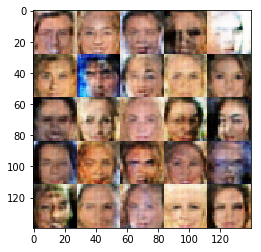

Epoch 1/1... Discriminator Loss: 1.2722... Generator Loss: 0.7557
Epoch 1/1... Discriminator Loss: 1.2516... Generator Loss: 1.4694
Epoch 1/1... Discriminator Loss: 1.3340... Generator Loss: 0.7598
Epoch 1/1... Discriminator Loss: 1.1877... Generator Loss: 0.7855
Epoch 1/1... Discriminator Loss: 1.2132... Generator Loss: 1.1302
Epoch 1/1... Discriminator Loss: 1.2671... Generator Loss: 0.7815
Epoch 1/1... Discriminator Loss: 1.3943... Generator Loss: 1.2637
Epoch 1/1... Discriminator Loss: 1.2823... Generator Loss: 0.7240
Epoch 1/1... Discriminator Loss: 1.3020... Generator Loss: 0.6709
Epoch 1/1... Discriminator Loss: 1.2851... Generator Loss: 0.7976


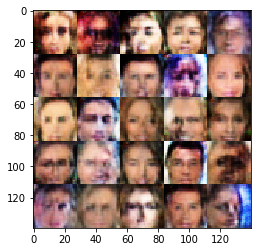

Epoch 1/1... Discriminator Loss: 1.5042... Generator Loss: 1.0995
Epoch 1/1... Discriminator Loss: 1.3208... Generator Loss: 1.2679
Epoch 1/1... Discriminator Loss: 1.1984... Generator Loss: 0.8383
Epoch 1/1... Discriminator Loss: 1.2545... Generator Loss: 0.8679
Epoch 1/1... Discriminator Loss: 1.0338... Generator Loss: 1.0223
Epoch 1/1... Discriminator Loss: 1.0565... Generator Loss: 0.9823
Epoch 1/1... Discriminator Loss: 1.4105... Generator Loss: 0.8321
Epoch 1/1... Discriminator Loss: 1.2605... Generator Loss: 0.8018
Epoch 1/1... Discriminator Loss: 1.4266... Generator Loss: 0.5634
Epoch 1/1... Discriminator Loss: 1.1795... Generator Loss: 0.9922


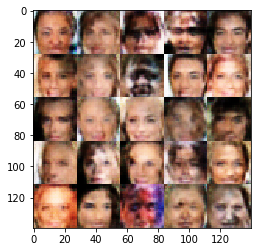

Epoch 1/1... Discriminator Loss: 1.1260... Generator Loss: 1.0311
Epoch 1/1... Discriminator Loss: 1.2972... Generator Loss: 1.2874
Epoch 1/1... Discriminator Loss: 1.2046... Generator Loss: 1.0202
Epoch 1/1... Discriminator Loss: 1.1374... Generator Loss: 0.9234
Epoch 1/1... Discriminator Loss: 1.0821... Generator Loss: 0.8262
Epoch 1/1... Discriminator Loss: 1.2056... Generator Loss: 0.6663
Epoch 1/1... Discriminator Loss: 1.2916... Generator Loss: 0.9373
Epoch 1/1... Discriminator Loss: 1.1491... Generator Loss: 1.0682
Epoch 1/1... Discriminator Loss: 1.3317... Generator Loss: 0.6469
Epoch 1/1... Discriminator Loss: 1.3246... Generator Loss: 0.7356


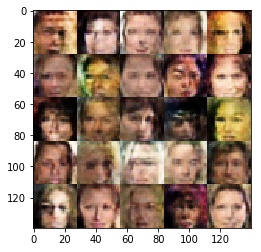

Epoch 1/1... Discriminator Loss: 1.2809... Generator Loss: 0.8613
Epoch 1/1... Discriminator Loss: 1.1981... Generator Loss: 1.0143
Epoch 1/1... Discriminator Loss: 0.9188... Generator Loss: 1.0778
Epoch 1/1... Discriminator Loss: 1.1679... Generator Loss: 1.0811
Epoch 1/1... Discriminator Loss: 1.2018... Generator Loss: 0.6350
Epoch 1/1... Discriminator Loss: 1.3054... Generator Loss: 0.8217
Epoch 1/1... Discriminator Loss: 1.4794... Generator Loss: 0.6918
Epoch 1/1... Discriminator Loss: 1.1847... Generator Loss: 1.2054
Epoch 1/1... Discriminator Loss: 1.4669... Generator Loss: 0.6315
Epoch 1/1... Discriminator Loss: 1.3380... Generator Loss: 1.6545


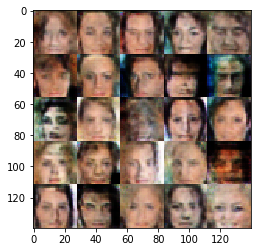

Epoch 1/1... Discriminator Loss: 1.3804... Generator Loss: 0.6273
Epoch 1/1... Discriminator Loss: 1.1251... Generator Loss: 0.9210
Epoch 1/1... Discriminator Loss: 1.2569... Generator Loss: 0.7954
Epoch 1/1... Discriminator Loss: 1.3988... Generator Loss: 0.7919
Epoch 1/1... Discriminator Loss: 1.3467... Generator Loss: 0.7063
Epoch 1/1... Discriminator Loss: 1.6044... Generator Loss: 0.5899
Epoch 1/1... Discriminator Loss: 1.2150... Generator Loss: 0.7501
Epoch 1/1... Discriminator Loss: 1.4440... Generator Loss: 0.7007
Epoch 1/1... Discriminator Loss: 1.0452... Generator Loss: 1.2133
Epoch 1/1... Discriminator Loss: 1.0818... Generator Loss: 0.7934


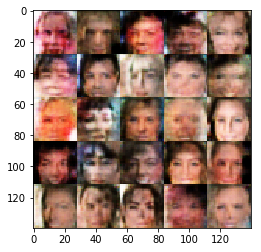

Epoch 1/1... Discriminator Loss: 1.2702... Generator Loss: 0.6754
Epoch 1/1... Discriminator Loss: 0.8424... Generator Loss: 1.3061
Epoch 1/1... Discriminator Loss: 1.3605... Generator Loss: 1.3840
Epoch 1/1... Discriminator Loss: 1.3652... Generator Loss: 0.5385
Epoch 1/1... Discriminator Loss: 1.4335... Generator Loss: 1.1176
Epoch 1/1... Discriminator Loss: 1.0887... Generator Loss: 1.0759
Epoch 1/1... Discriminator Loss: 1.4973... Generator Loss: 0.8950
Epoch 1/1... Discriminator Loss: 1.1978... Generator Loss: 0.9985
Epoch 1/1... Discriminator Loss: 1.3509... Generator Loss: 0.6465
Epoch 1/1... Discriminator Loss: 1.3320... Generator Loss: 0.8476


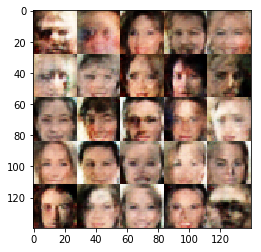

Epoch 1/1... Discriminator Loss: 1.4231... Generator Loss: 0.5934
Epoch 1/1... Discriminator Loss: 1.1314... Generator Loss: 0.9202
Epoch 1/1... Discriminator Loss: 1.3143... Generator Loss: 1.5403
Epoch 1/1... Discriminator Loss: 1.4361... Generator Loss: 0.4859
Epoch 1/1... Discriminator Loss: 1.0924... Generator Loss: 0.9223
Epoch 1/1... Discriminator Loss: 1.1670... Generator Loss: 0.7227
Epoch 1/1... Discriminator Loss: 1.3452... Generator Loss: 0.5602
Epoch 1/1... Discriminator Loss: 1.1604... Generator Loss: 0.8113
Epoch 1/1... Discriminator Loss: 1.0787... Generator Loss: 1.1663
Epoch 1/1... Discriminator Loss: 1.2762... Generator Loss: 1.0168


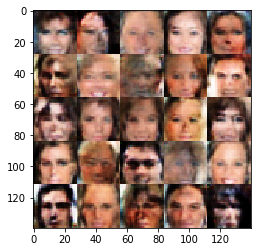

Epoch 1/1... Discriminator Loss: 1.1539... Generator Loss: 0.8278
Epoch 1/1... Discriminator Loss: 1.3985... Generator Loss: 0.7446
Epoch 1/1... Discriminator Loss: 1.0747... Generator Loss: 0.9554
Epoch 1/1... Discriminator Loss: 1.1548... Generator Loss: 0.8608
Epoch 1/1... Discriminator Loss: 1.3300... Generator Loss: 0.6442
Epoch 1/1... Discriminator Loss: 1.3655... Generator Loss: 0.7178
Epoch 1/1... Discriminator Loss: 1.1801... Generator Loss: 0.8776
Epoch 1/1... Discriminator Loss: 1.4702... Generator Loss: 1.1762
Epoch 1/1... Discriminator Loss: 1.2839... Generator Loss: 1.0609
Epoch 1/1... Discriminator Loss: 1.4746... Generator Loss: 0.5155


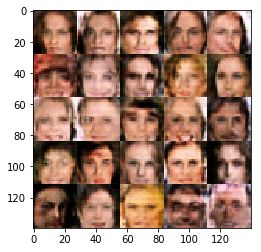

Epoch 1/1... Discriminator Loss: 1.2063... Generator Loss: 0.9852
Epoch 1/1... Discriminator Loss: 1.2953... Generator Loss: 0.6900
Epoch 1/1... Discriminator Loss: 1.2417... Generator Loss: 0.9173
Epoch 1/1... Discriminator Loss: 1.1950... Generator Loss: 1.0039
Epoch 1/1... Discriminator Loss: 1.3178... Generator Loss: 0.6009
Epoch 1/1... Discriminator Loss: 1.3158... Generator Loss: 0.8287
Epoch 1/1... Discriminator Loss: 1.3016... Generator Loss: 1.0010
Epoch 1/1... Discriminator Loss: 1.3739... Generator Loss: 0.6416
Epoch 1/1... Discriminator Loss: 1.2833... Generator Loss: 0.6559
Epoch 1/1... Discriminator Loss: 1.2486... Generator Loss: 0.7403


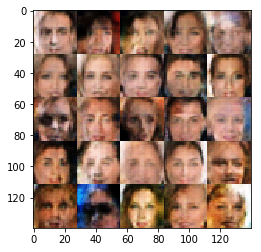

Epoch 1/1... Discriminator Loss: 1.6119... Generator Loss: 0.3862
Epoch 1/1... Discriminator Loss: 1.1991... Generator Loss: 0.9971
Epoch 1/1... Discriminator Loss: 1.4074... Generator Loss: 0.6665
Epoch 1/1... Discriminator Loss: 1.1261... Generator Loss: 0.9560
Epoch 1/1... Discriminator Loss: 1.2943... Generator Loss: 0.7027
Epoch 1/1... Discriminator Loss: 0.9336... Generator Loss: 1.0106
Epoch 1/1... Discriminator Loss: 1.0380... Generator Loss: 1.2016
Epoch 1/1... Discriminator Loss: 1.3832... Generator Loss: 0.8214
Epoch 1/1... Discriminator Loss: 1.3234... Generator Loss: 0.7158
Epoch 1/1... Discriminator Loss: 1.0960... Generator Loss: 0.9012


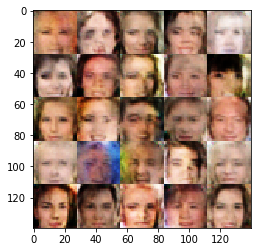

Epoch 1/1... Discriminator Loss: 1.1502... Generator Loss: 0.7741
Epoch 1/1... Discriminator Loss: 1.4120... Generator Loss: 0.5160
Epoch 1/1... Discriminator Loss: 1.1330... Generator Loss: 0.9910
Epoch 1/1... Discriminator Loss: 1.4018... Generator Loss: 0.5285
Epoch 1/1... Discriminator Loss: 1.2280... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.2702... Generator Loss: 0.9012
Epoch 1/1... Discriminator Loss: 1.2731... Generator Loss: 0.6731
Epoch 1/1... Discriminator Loss: 1.2605... Generator Loss: 0.8201
Epoch 1/1... Discriminator Loss: 1.4998... Generator Loss: 0.4860
Epoch 1/1... Discriminator Loss: 1.2725... Generator Loss: 0.8675


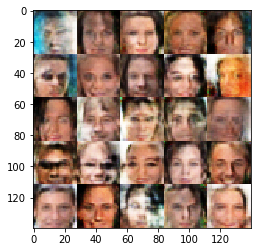

Epoch 1/1... Discriminator Loss: 1.3542... Generator Loss: 1.1931
Epoch 1/1... Discriminator Loss: 0.9945... Generator Loss: 1.0588
Epoch 1/1... Discriminator Loss: 1.5404... Generator Loss: 0.5377
Epoch 1/1... Discriminator Loss: 1.1905... Generator Loss: 0.7702
Epoch 1/1... Discriminator Loss: 1.3589... Generator Loss: 0.7691
Epoch 1/1... Discriminator Loss: 1.3466... Generator Loss: 0.6071
Epoch 1/1... Discriminator Loss: 1.2562... Generator Loss: 0.7824
Epoch 1/1... Discriminator Loss: 1.0350... Generator Loss: 1.1460
Epoch 1/1... Discriminator Loss: 1.2374... Generator Loss: 0.6893
Epoch 1/1... Discriminator Loss: 1.2167... Generator Loss: 0.9015


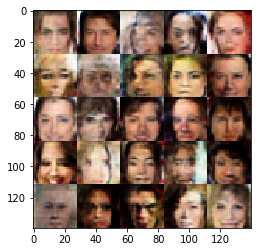

Epoch 1/1... Discriminator Loss: 1.1910... Generator Loss: 1.0192
Epoch 1/1... Discriminator Loss: 1.1213... Generator Loss: 1.0018
Epoch 1/1... Discriminator Loss: 1.4764... Generator Loss: 0.5473
Epoch 1/1... Discriminator Loss: 1.1350... Generator Loss: 0.9366
Epoch 1/1... Discriminator Loss: 1.2389... Generator Loss: 1.1785
Epoch 1/1... Discriminator Loss: 1.4095... Generator Loss: 0.5561
Epoch 1/1... Discriminator Loss: 1.1470... Generator Loss: 0.8846
Epoch 1/1... Discriminator Loss: 1.3427... Generator Loss: 0.7216
Epoch 1/1... Discriminator Loss: 1.4139... Generator Loss: 0.9080
Epoch 1/1... Discriminator Loss: 1.2951... Generator Loss: 0.6389


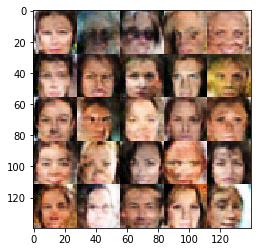

Epoch 1/1... Discriminator Loss: 1.3484... Generator Loss: 0.8607
Epoch 1/1... Discriminator Loss: 1.1770... Generator Loss: 0.8286
Epoch 1/1... Discriminator Loss: 1.3645... Generator Loss: 1.2373
Epoch 1/1... Discriminator Loss: 1.0776... Generator Loss: 1.1037
Epoch 1/1... Discriminator Loss: 0.9841... Generator Loss: 1.1048
Epoch 1/1... Discriminator Loss: 1.4274... Generator Loss: 0.7094
Epoch 1/1... Discriminator Loss: 1.4377... Generator Loss: 0.6115
Epoch 1/1... Discriminator Loss: 1.3181... Generator Loss: 1.1929
Epoch 1/1... Discriminator Loss: 1.2785... Generator Loss: 0.6434
Epoch 1/1... Discriminator Loss: 1.2083... Generator Loss: 0.8187


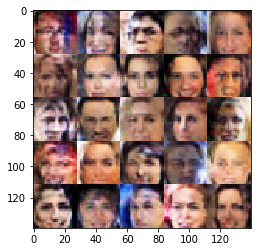

Epoch 1/1... Discriminator Loss: 1.0818... Generator Loss: 1.0503
Epoch 1/1... Discriminator Loss: 1.1683... Generator Loss: 0.7700
Epoch 1/1... Discriminator Loss: 1.3354... Generator Loss: 0.7433
Epoch 1/1... Discriminator Loss: 1.3363... Generator Loss: 0.6580
Epoch 1/1... Discriminator Loss: 1.4206... Generator Loss: 0.7429
Epoch 1/1... Discriminator Loss: 1.4764... Generator Loss: 0.5250
Epoch 1/1... Discriminator Loss: 1.1883... Generator Loss: 0.8084
Epoch 1/1... Discriminator Loss: 1.2130... Generator Loss: 0.6995
Epoch 1/1... Discriminator Loss: 1.3767... Generator Loss: 0.7974
Epoch 1/1... Discriminator Loss: 1.4122... Generator Loss: 0.7061


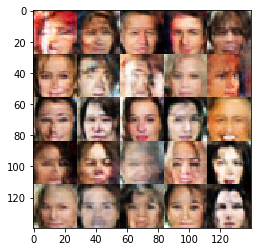

Epoch 1/1... Discriminator Loss: 1.2644... Generator Loss: 0.8345
Epoch 1/1... Discriminator Loss: 1.1327... Generator Loss: 0.9502
Epoch 1/1... Discriminator Loss: 1.4185... Generator Loss: 0.6816
Epoch 1/1... Discriminator Loss: 1.2144... Generator Loss: 0.8396
Epoch 1/1... Discriminator Loss: 1.3993... Generator Loss: 1.5292
Epoch 1/1... Discriminator Loss: 1.1974... Generator Loss: 1.0631
Epoch 1/1... Discriminator Loss: 1.2728... Generator Loss: 0.9598
Epoch 1/1... Discriminator Loss: 1.0997... Generator Loss: 0.9177
Epoch 1/1... Discriminator Loss: 1.2498... Generator Loss: 0.9164
Epoch 1/1... Discriminator Loss: 1.4478... Generator Loss: 1.4566


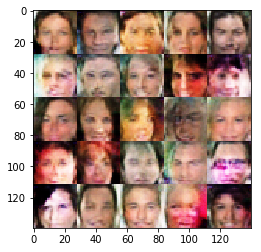

Epoch 1/1... Discriminator Loss: 1.2381... Generator Loss: 1.0762
Epoch 1/1... Discriminator Loss: 1.1174... Generator Loss: 0.8857
Epoch 1/1... Discriminator Loss: 1.3826... Generator Loss: 0.6842
Epoch 1/1... Discriminator Loss: 1.3379... Generator Loss: 0.5349
Epoch 1/1... Discriminator Loss: 1.2324... Generator Loss: 0.7166
Epoch 1/1... Discriminator Loss: 1.2336... Generator Loss: 1.0723
Epoch 1/1... Discriminator Loss: 1.4171... Generator Loss: 0.6503
Epoch 1/1... Discriminator Loss: 1.3207... Generator Loss: 0.8153
Epoch 1/1... Discriminator Loss: 1.1677... Generator Loss: 0.7661
Epoch 1/1... Discriminator Loss: 1.3712... Generator Loss: 0.7264


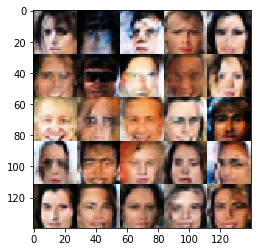

Epoch 1/1... Discriminator Loss: 1.1820... Generator Loss: 0.6877
Epoch 1/1... Discriminator Loss: 1.2561... Generator Loss: 1.0602
Epoch 1/1... Discriminator Loss: 1.3653... Generator Loss: 0.6686
Epoch 1/1... Discriminator Loss: 1.3898... Generator Loss: 0.6489
Epoch 1/1... Discriminator Loss: 1.2342... Generator Loss: 0.7481
Epoch 1/1... Discriminator Loss: 1.1408... Generator Loss: 0.9419
Epoch 1/1... Discriminator Loss: 1.2830... Generator Loss: 0.8257
Epoch 1/1... Discriminator Loss: 1.3407... Generator Loss: 0.7007
Epoch 1/1... Discriminator Loss: 1.3408... Generator Loss: 0.5814
Epoch 1/1... Discriminator Loss: 1.2925... Generator Loss: 0.8297


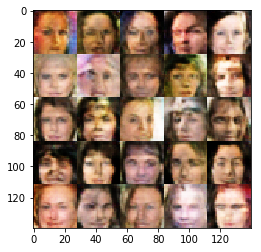

Epoch 1/1... Discriminator Loss: 1.2184... Generator Loss: 0.8321
Epoch 1/1... Discriminator Loss: 1.2664... Generator Loss: 0.6201
Epoch 1/1... Discriminator Loss: 1.2323... Generator Loss: 0.6943
Epoch 1/1... Discriminator Loss: 0.9727... Generator Loss: 1.3079
Epoch 1/1... Discriminator Loss: 1.0879... Generator Loss: 1.0198
Epoch 1/1... Discriminator Loss: 1.3298... Generator Loss: 0.7834
Epoch 1/1... Discriminator Loss: 1.3738... Generator Loss: 0.5658
Epoch 1/1... Discriminator Loss: 1.2264... Generator Loss: 0.9259
Epoch 1/1... Discriminator Loss: 1.2967... Generator Loss: 0.7755
Epoch 1/1... Discriminator Loss: 1.5144... Generator Loss: 0.5049


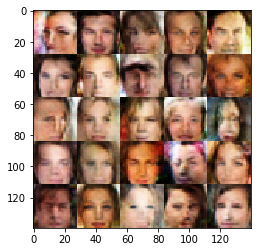

Epoch 1/1... Discriminator Loss: 0.9962... Generator Loss: 1.2516
Epoch 1/1... Discriminator Loss: 1.2548... Generator Loss: 0.7486
Epoch 1/1... Discriminator Loss: 1.3663... Generator Loss: 0.9281
Epoch 1/1... Discriminator Loss: 1.3670... Generator Loss: 0.7526
Epoch 1/1... Discriminator Loss: 1.2683... Generator Loss: 0.7528
Epoch 1/1... Discriminator Loss: 1.2758... Generator Loss: 0.7558
Epoch 1/1... Discriminator Loss: 1.3964... Generator Loss: 0.5936
Epoch 1/1... Discriminator Loss: 1.1710... Generator Loss: 0.9784
Epoch 1/1... Discriminator Loss: 0.8687... Generator Loss: 1.2228
Epoch 1/1... Discriminator Loss: 1.1431... Generator Loss: 0.9313


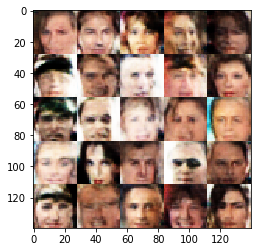

Epoch 1/1... Discriminator Loss: 1.3912... Generator Loss: 0.5591
Epoch 1/1... Discriminator Loss: 1.3109... Generator Loss: 0.8425
Epoch 1/1... Discriminator Loss: 1.1595... Generator Loss: 0.8292
Epoch 1/1... Discriminator Loss: 1.1338... Generator Loss: 0.7537
Epoch 1/1... Discriminator Loss: 1.2181... Generator Loss: 0.6725
Epoch 1/1... Discriminator Loss: 1.3300... Generator Loss: 0.8041
Epoch 1/1... Discriminator Loss: 1.7013... Generator Loss: 1.5513
Epoch 1/1... Discriminator Loss: 1.3684... Generator Loss: 0.7213
Epoch 1/1... Discriminator Loss: 1.0359... Generator Loss: 1.1480
Epoch 1/1... Discriminator Loss: 1.1997... Generator Loss: 0.8265


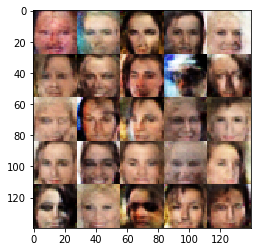

Epoch 1/1... Discriminator Loss: 1.4041... Generator Loss: 1.4919
Epoch 1/1... Discriminator Loss: 1.2240... Generator Loss: 1.0734
Epoch 1/1... Discriminator Loss: 1.0961... Generator Loss: 0.9217
Epoch 1/1... Discriminator Loss: 1.2995... Generator Loss: 0.8033
Epoch 1/1... Discriminator Loss: 1.4196... Generator Loss: 0.5761
Epoch 1/1... Discriminator Loss: 1.1629... Generator Loss: 0.7875
Epoch 1/1... Discriminator Loss: 1.3086... Generator Loss: 0.5912
Epoch 1/1... Discriminator Loss: 1.1326... Generator Loss: 1.2421
Epoch 1/1... Discriminator Loss: 1.0024... Generator Loss: 0.9920
Epoch 1/1... Discriminator Loss: 1.2459... Generator Loss: 0.7650


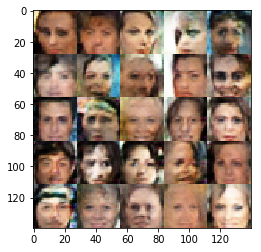

Epoch 1/1... Discriminator Loss: 1.1570... Generator Loss: 0.8178
Epoch 1/1... Discriminator Loss: 1.2469... Generator Loss: 0.8305
Epoch 1/1... Discriminator Loss: 1.2185... Generator Loss: 0.8380
Epoch 1/1... Discriminator Loss: 1.0482... Generator Loss: 1.3256
Epoch 1/1... Discriminator Loss: 1.4100... Generator Loss: 0.5175
Epoch 1/1... Discriminator Loss: 1.3984... Generator Loss: 0.7039
Epoch 1/1... Discriminator Loss: 1.2607... Generator Loss: 0.6788
Epoch 1/1... Discriminator Loss: 1.1212... Generator Loss: 1.0011
Epoch 1/1... Discriminator Loss: 1.0778... Generator Loss: 0.8800
Epoch 1/1... Discriminator Loss: 0.9240... Generator Loss: 1.2302


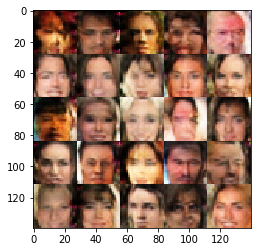

Epoch 1/1... Discriminator Loss: 1.3309... Generator Loss: 0.9465
Epoch 1/1... Discriminator Loss: 1.2623... Generator Loss: 0.8514
Epoch 1/1... Discriminator Loss: 1.2570... Generator Loss: 1.0421
Epoch 1/1... Discriminator Loss: 1.2566... Generator Loss: 1.0513
Epoch 1/1... Discriminator Loss: 1.1689... Generator Loss: 1.0052
Epoch 1/1... Discriminator Loss: 1.3817... Generator Loss: 0.5366
Epoch 1/1... Discriminator Loss: 1.0829... Generator Loss: 0.9828
Epoch 1/1... Discriminator Loss: 1.7080... Generator Loss: 0.6049
Epoch 1/1... Discriminator Loss: 1.2501... Generator Loss: 0.9242
Epoch 1/1... Discriminator Loss: 1.1667... Generator Loss: 1.4213


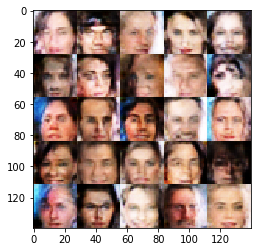

Epoch 1/1... Discriminator Loss: 1.2328... Generator Loss: 0.6893
Epoch 1/1... Discriminator Loss: 1.3042... Generator Loss: 0.6602
Epoch 1/1... Discriminator Loss: 1.1871... Generator Loss: 1.0008
Epoch 1/1... Discriminator Loss: 1.3600... Generator Loss: 0.8457
Epoch 1/1... Discriminator Loss: 1.3106... Generator Loss: 0.7561
Epoch 1/1... Discriminator Loss: 1.2044... Generator Loss: 0.7750
Epoch 1/1... Discriminator Loss: 1.3823... Generator Loss: 0.6243
Epoch 1/1... Discriminator Loss: 0.9158... Generator Loss: 1.1754
Epoch 1/1... Discriminator Loss: 1.4343... Generator Loss: 0.6277
Epoch 1/1... Discriminator Loss: 1.4401... Generator Loss: 0.4835


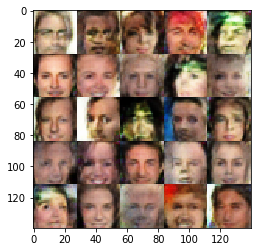

Epoch 1/1... Discriminator Loss: 1.2604... Generator Loss: 0.6902
Epoch 1/1... Discriminator Loss: 1.3629... Generator Loss: 0.7015
Epoch 1/1... Discriminator Loss: 1.1924... Generator Loss: 0.7945
Epoch 1/1... Discriminator Loss: 1.0295... Generator Loss: 1.3468
Epoch 1/1... Discriminator Loss: 1.1968... Generator Loss: 0.9244
Epoch 1/1... Discriminator Loss: 1.3337... Generator Loss: 0.7757
Epoch 1/1... Discriminator Loss: 1.4984... Generator Loss: 0.4670
Epoch 1/1... Discriminator Loss: 1.2099... Generator Loss: 1.2118
Epoch 1/1... Discriminator Loss: 1.0530... Generator Loss: 1.1140
Epoch 1/1... Discriminator Loss: 1.3154... Generator Loss: 0.6216


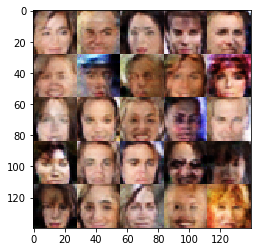

Epoch 1/1... Discriminator Loss: 1.2606... Generator Loss: 0.8439
Epoch 1/1... Discriminator Loss: 1.3265... Generator Loss: 0.6305
Epoch 1/1... Discriminator Loss: 1.4208... Generator Loss: 0.5928
Epoch 1/1... Discriminator Loss: 1.2565... Generator Loss: 1.1529
Epoch 1/1... Discriminator Loss: 1.3396... Generator Loss: 0.7860
Epoch 1/1... Discriminator Loss: 1.4807... Generator Loss: 0.5140
Epoch 1/1... Discriminator Loss: 1.3102... Generator Loss: 0.7362
Epoch 1/1... Discriminator Loss: 1.1971... Generator Loss: 0.8046
Epoch 1/1... Discriminator Loss: 1.1272... Generator Loss: 1.0000
Epoch 1/1... Discriminator Loss: 1.5838... Generator Loss: 0.4643


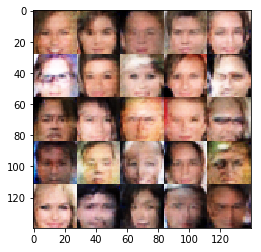

Epoch 1/1... Discriminator Loss: 1.0838... Generator Loss: 1.1985
Epoch 1/1... Discriminator Loss: 1.6939... Generator Loss: 0.4129
Epoch 1/1... Discriminator Loss: 1.2998... Generator Loss: 0.8893
Epoch 1/1... Discriminator Loss: 1.4146... Generator Loss: 1.0020
Epoch 1/1... Discriminator Loss: 1.2901... Generator Loss: 0.7970
Epoch 1/1... Discriminator Loss: 1.3077... Generator Loss: 0.7869
Epoch 1/1... Discriminator Loss: 1.4471... Generator Loss: 0.7521
Epoch 1/1... Discriminator Loss: 1.3818... Generator Loss: 0.6975
Epoch 1/1... Discriminator Loss: 0.8052... Generator Loss: 1.8403
Epoch 1/1... Discriminator Loss: 1.3633... Generator Loss: 0.7415


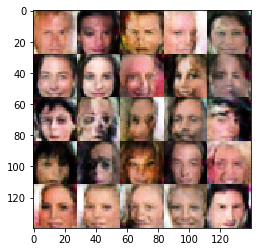

Epoch 1/1... Discriminator Loss: 1.2579... Generator Loss: 0.6245
Epoch 1/1... Discriminator Loss: 1.3631... Generator Loss: 0.6142
Epoch 1/1... Discriminator Loss: 1.3586... Generator Loss: 0.7649
Epoch 1/1... Discriminator Loss: 1.4360... Generator Loss: 0.5512
Epoch 1/1... Discriminator Loss: 1.3866... Generator Loss: 0.6538
Epoch 1/1... Discriminator Loss: 1.2031... Generator Loss: 0.7820
Epoch 1/1... Discriminator Loss: 1.1968... Generator Loss: 0.9234
Epoch 1/1... Discriminator Loss: 1.3938... Generator Loss: 0.7450
Epoch 1/1... Discriminator Loss: 1.1803... Generator Loss: 0.7396
Epoch 1/1... Discriminator Loss: 1.2587... Generator Loss: 0.6998


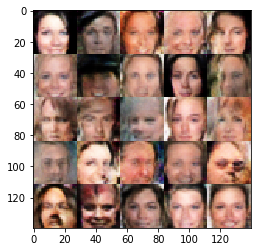

Epoch 1/1... Discriminator Loss: 1.4438... Generator Loss: 0.5382
Epoch 1/1... Discriminator Loss: 1.0608... Generator Loss: 0.9270
Epoch 1/1... Discriminator Loss: 1.3566... Generator Loss: 0.8699
Epoch 1/1... Discriminator Loss: 1.2398... Generator Loss: 1.1317
Epoch 1/1... Discriminator Loss: 1.0851... Generator Loss: 0.9933
Epoch 1/1... Discriminator Loss: 1.2575... Generator Loss: 0.7216
Epoch 1/1... Discriminator Loss: 1.2878... Generator Loss: 0.9334
Epoch 1/1... Discriminator Loss: 1.2501... Generator Loss: 0.7523
Epoch 1/1... Discriminator Loss: 1.2803... Generator Loss: 0.7025
Epoch 1/1... Discriminator Loss: 1.2083... Generator Loss: 0.8604


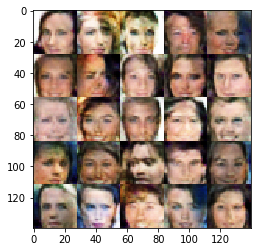

Epoch 1/1... Discriminator Loss: 1.3918... Generator Loss: 0.6386
Epoch 1/1... Discriminator Loss: 1.3184... Generator Loss: 0.7697
Epoch 1/1... Discriminator Loss: 1.1719... Generator Loss: 0.8881
Epoch 1/1... Discriminator Loss: 1.2151... Generator Loss: 0.8361
Epoch 1/1... Discriminator Loss: 1.3465... Generator Loss: 0.7901
Epoch 1/1... Discriminator Loss: 1.3822... Generator Loss: 0.7102
Epoch 1/1... Discriminator Loss: 1.3479... Generator Loss: 0.7784
Epoch 1/1... Discriminator Loss: 1.2022... Generator Loss: 0.8564
Epoch 1/1... Discriminator Loss: 1.3186... Generator Loss: 0.8147
Epoch 1/1... Discriminator Loss: 1.4556... Generator Loss: 0.6861


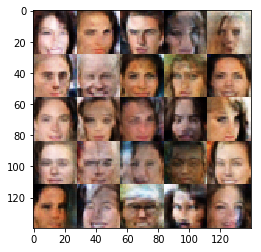

Epoch 1/1... Discriminator Loss: 1.3214... Generator Loss: 0.7226
Epoch 1/1... Discriminator Loss: 1.4278... Generator Loss: 0.6740
Epoch 1/1... Discriminator Loss: 1.4344... Generator Loss: 0.6752
Epoch 1/1... Discriminator Loss: 1.3783... Generator Loss: 0.8782
Epoch 1/1... Discriminator Loss: 1.4542... Generator Loss: 0.5399
Epoch 1/1... Discriminator Loss: 1.3374... Generator Loss: 0.7143
Epoch 1/1... Discriminator Loss: 1.4283... Generator Loss: 0.5797
Epoch 1/1... Discriminator Loss: 1.3630... Generator Loss: 0.6296
Epoch 1/1... Discriminator Loss: 1.2685... Generator Loss: 0.8821
Epoch 1/1... Discriminator Loss: 1.2694... Generator Loss: 0.8682


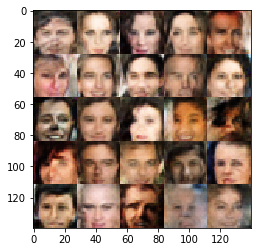

Epoch 1/1... Discriminator Loss: 1.3082... Generator Loss: 0.9267
Epoch 1/1... Discriminator Loss: 1.2874... Generator Loss: 0.8811
Epoch 1/1... Discriminator Loss: 1.0515... Generator Loss: 0.9679
Epoch 1/1... Discriminator Loss: 1.2109... Generator Loss: 0.9401
Epoch 1/1... Discriminator Loss: 1.0875... Generator Loss: 1.0154
Epoch 1/1... Discriminator Loss: 1.3565... Generator Loss: 0.6878
Epoch 1/1... Discriminator Loss: 1.3233... Generator Loss: 0.6925
Epoch 1/1... Discriminator Loss: 1.3555... Generator Loss: 0.8411
Epoch 1/1... Discriminator Loss: 1.1620... Generator Loss: 0.9419
Epoch 1/1... Discriminator Loss: 1.4214... Generator Loss: 0.6044


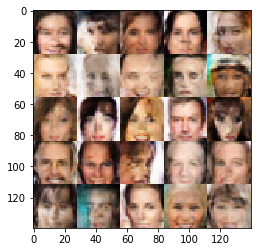

Epoch 1/1... Discriminator Loss: 1.3505... Generator Loss: 0.6980
Epoch 1/1... Discriminator Loss: 1.1491... Generator Loss: 0.9928
Epoch 1/1... Discriminator Loss: 1.4757... Generator Loss: 0.6150
Epoch 1/1... Discriminator Loss: 1.3730... Generator Loss: 0.6682
Epoch 1/1... Discriminator Loss: 1.1744... Generator Loss: 0.9970
Epoch 1/1... Discriminator Loss: 1.1487... Generator Loss: 0.8499
Epoch 1/1... Discriminator Loss: 1.3445... Generator Loss: 0.7129
Epoch 1/1... Discriminator Loss: 1.3680... Generator Loss: 0.6606
Epoch 1/1... Discriminator Loss: 1.2871... Generator Loss: 0.8478
Epoch 1/1... Discriminator Loss: 1.2285... Generator Loss: 0.8339


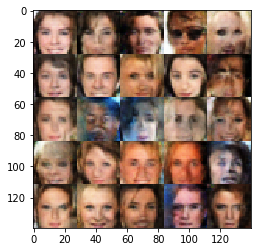

Epoch 1/1... Discriminator Loss: 1.3410... Generator Loss: 0.6759
Epoch 1/1... Discriminator Loss: 1.4001... Generator Loss: 0.6824
Epoch 1/1... Discriminator Loss: 1.3242... Generator Loss: 0.7535
Epoch 1/1... Discriminator Loss: 1.3538... Generator Loss: 1.0155
Epoch 1/1... Discriminator Loss: 1.3335... Generator Loss: 0.7326
Epoch 1/1... Discriminator Loss: 1.2350... Generator Loss: 0.7284
Epoch 1/1... Discriminator Loss: 1.5447... Generator Loss: 0.5525
Epoch 1/1... Discriminator Loss: 1.1971... Generator Loss: 0.8749
Epoch 1/1... Discriminator Loss: 1.2762... Generator Loss: 0.7597
Epoch 1/1... Discriminator Loss: 1.3078... Generator Loss: 0.8303


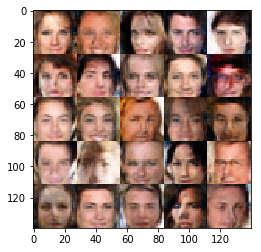

Epoch 1/1... Discriminator Loss: 1.2890... Generator Loss: 0.7050
Epoch 1/1... Discriminator Loss: 1.2704... Generator Loss: 0.7570
Epoch 1/1... Discriminator Loss: 1.3248... Generator Loss: 0.6500
Epoch 1/1... Discriminator Loss: 1.2689... Generator Loss: 0.9686
Epoch 1/1... Discriminator Loss: 1.4628... Generator Loss: 0.5051
Epoch 1/1... Discriminator Loss: 1.4339... Generator Loss: 0.7188
Epoch 1/1... Discriminator Loss: 1.2913... Generator Loss: 0.7937
Epoch 1/1... Discriminator Loss: 1.4226... Generator Loss: 0.7121
Epoch 1/1... Discriminator Loss: 1.3371... Generator Loss: 0.6358
Epoch 1/1... Discriminator Loss: 1.3732... Generator Loss: 0.6078


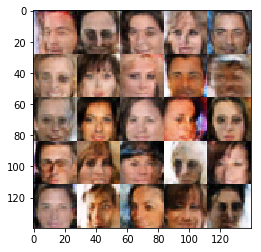

Epoch 1/1... Discriminator Loss: 1.3264... Generator Loss: 0.8603
Epoch 1/1... Discriminator Loss: 1.5135... Generator Loss: 0.5597
Epoch 1/1... Discriminator Loss: 1.2717... Generator Loss: 0.7633
Epoch 1/1... Discriminator Loss: 1.1734... Generator Loss: 1.0171
Epoch 1/1... Discriminator Loss: 1.0625... Generator Loss: 0.9584
Epoch 1/1... Discriminator Loss: 1.1858... Generator Loss: 1.0471
Epoch 1/1... Discriminator Loss: 1.3595... Generator Loss: 0.6884
Epoch 1/1... Discriminator Loss: 1.3288... Generator Loss: 0.7437
Epoch 1/1... Discriminator Loss: 1.2259... Generator Loss: 0.9009
Epoch 1/1... Discriminator Loss: 1.2473... Generator Loss: 0.9678


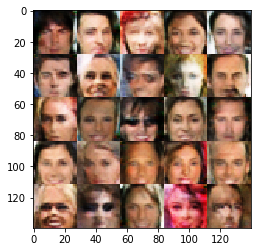

Epoch 1/1... Discriminator Loss: 1.2227... Generator Loss: 0.8210
Epoch 1/1... Discriminator Loss: 1.2743... Generator Loss: 0.6897
Epoch 1/1... Discriminator Loss: 1.3306... Generator Loss: 0.6966
Epoch 1/1... Discriminator Loss: 1.2605... Generator Loss: 0.8492
Epoch 1/1... Discriminator Loss: 1.3448... Generator Loss: 0.9310
Epoch 1/1... Discriminator Loss: 1.3219... Generator Loss: 0.7443
Epoch 1/1... Discriminator Loss: 1.2675... Generator Loss: 0.7013
Epoch 1/1... Discriminator Loss: 1.3285... Generator Loss: 0.8931
Epoch 1/1... Discriminator Loss: 1.2530... Generator Loss: 0.7861
Epoch 1/1... Discriminator Loss: 1.5034... Generator Loss: 0.5745


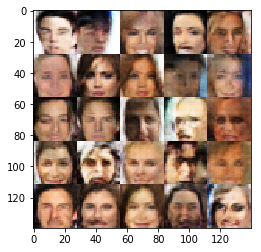

Epoch 1/1... Discriminator Loss: 1.2314... Generator Loss: 0.7585
Epoch 1/1... Discriminator Loss: 1.4778... Generator Loss: 0.5677
Epoch 1/1... Discriminator Loss: 1.1992... Generator Loss: 0.8704
Epoch 1/1... Discriminator Loss: 1.5061... Generator Loss: 0.5515
Epoch 1/1... Discriminator Loss: 1.2297... Generator Loss: 0.9664
Epoch 1/1... Discriminator Loss: 1.2991... Generator Loss: 0.7845
Epoch 1/1... Discriminator Loss: 1.3377... Generator Loss: 0.6743
Epoch 1/1... Discriminator Loss: 1.2875... Generator Loss: 0.8230
Epoch 1/1... Discriminator Loss: 1.3050... Generator Loss: 0.7529
Epoch 1/1... Discriminator Loss: 1.3001... Generator Loss: 0.7367


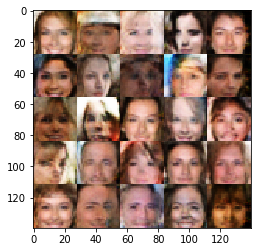

Epoch 1/1... Discriminator Loss: 1.3831... Generator Loss: 0.9988
Epoch 1/1... Discriminator Loss: 1.2843... Generator Loss: 0.6911
Epoch 1/1... Discriminator Loss: 1.3137... Generator Loss: 0.7555
Epoch 1/1... Discriminator Loss: 1.1998... Generator Loss: 0.8885
Epoch 1/1... Discriminator Loss: 1.1568... Generator Loss: 0.9130
Epoch 1/1... Discriminator Loss: 1.1709... Generator Loss: 0.8720
Epoch 1/1... Discriminator Loss: 1.4090... Generator Loss: 0.7790
Epoch 1/1... Discriminator Loss: 1.1559... Generator Loss: 0.9387
Epoch 1/1... Discriminator Loss: 1.3176... Generator Loss: 0.6625
Epoch 1/1... Discriminator Loss: 1.2531... Generator Loss: 0.8535


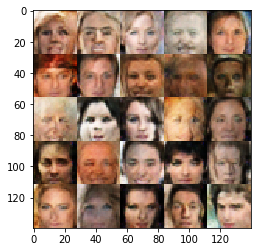

Epoch 1/1... Discriminator Loss: 1.3811... Generator Loss: 0.7105
Epoch 1/1... Discriminator Loss: 1.2944... Generator Loss: 0.8128
Epoch 1/1... Discriminator Loss: 1.3188... Generator Loss: 0.7800
Epoch 1/1... Discriminator Loss: 1.2127... Generator Loss: 0.8005
Epoch 1/1... Discriminator Loss: 1.5452... Generator Loss: 0.6448
Epoch 1/1... Discriminator Loss: 1.3049... Generator Loss: 0.7803
Epoch 1/1... Discriminator Loss: 1.3529... Generator Loss: 0.7952
Epoch 1/1... Discriminator Loss: 1.3285... Generator Loss: 0.9326
Epoch 1/1... Discriminator Loss: 1.2999... Generator Loss: 0.8374
Epoch 1/1... Discriminator Loss: 1.5000... Generator Loss: 0.5564


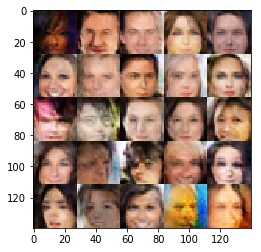

Epoch 1/1... Discriminator Loss: 1.2169... Generator Loss: 0.7865
Epoch 1/1... Discriminator Loss: 1.5296... Generator Loss: 0.8176
Epoch 1/1... Discriminator Loss: 1.4622... Generator Loss: 0.5595
Epoch 1/1... Discriminator Loss: 1.3194... Generator Loss: 0.6737
Epoch 1/1... Discriminator Loss: 1.2769... Generator Loss: 0.9250
Epoch 1/1... Discriminator Loss: 1.4881... Generator Loss: 0.6021
Epoch 1/1... Discriminator Loss: 1.2669... Generator Loss: 0.7781
Epoch 1/1... Discriminator Loss: 1.3251... Generator Loss: 0.7693
Epoch 1/1... Discriminator Loss: 1.1505... Generator Loss: 0.9421
Epoch 1/1... Discriminator Loss: 1.2036... Generator Loss: 0.7972


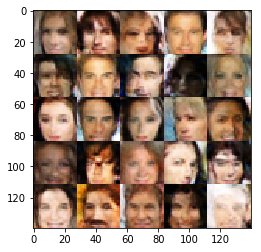

Epoch 1/1... Discriminator Loss: 1.3859... Generator Loss: 0.6807
Epoch 1/1... Discriminator Loss: 1.3856... Generator Loss: 0.7205
Epoch 1/1... Discriminator Loss: 1.1255... Generator Loss: 1.0350
Epoch 1/1... Discriminator Loss: 1.0970... Generator Loss: 0.9296
Epoch 1/1... Discriminator Loss: 1.2920... Generator Loss: 0.8816
Epoch 1/1... Discriminator Loss: 1.3098... Generator Loss: 0.7566
Epoch 1/1... Discriminator Loss: 1.3241... Generator Loss: 0.7565
Epoch 1/1... Discriminator Loss: 1.2785... Generator Loss: 0.8424
Epoch 1/1... Discriminator Loss: 1.2567... Generator Loss: 0.7610
Epoch 1/1... Discriminator Loss: 1.2074... Generator Loss: 0.8583


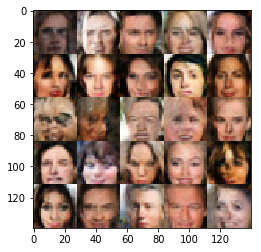

Epoch 1/1... Discriminator Loss: 1.3868... Generator Loss: 0.6104
Epoch 1/1... Discriminator Loss: 1.3490... Generator Loss: 0.8903
Epoch 1/1... Discriminator Loss: 1.3399... Generator Loss: 0.6651
Epoch 1/1... Discriminator Loss: 1.2588... Generator Loss: 0.8211
Epoch 1/1... Discriminator Loss: 1.2515... Generator Loss: 0.8266
Epoch 1/1... Discriminator Loss: 1.1984... Generator Loss: 1.1047
Epoch 1/1... Discriminator Loss: 1.2809... Generator Loss: 0.7756
Epoch 1/1... Discriminator Loss: 1.3797... Generator Loss: 0.7958
Epoch 1/1... Discriminator Loss: 1.4649... Generator Loss: 0.5909
Epoch 1/1... Discriminator Loss: 1.1691... Generator Loss: 0.8836


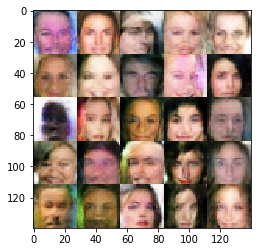

Epoch 1/1... Discriminator Loss: 1.3366... Generator Loss: 0.8675
Epoch 1/1... Discriminator Loss: 1.3052... Generator Loss: 0.7919
Epoch 1/1... Discriminator Loss: 1.4789... Generator Loss: 0.6908
Epoch 1/1... Discriminator Loss: 1.1419... Generator Loss: 0.9928
Epoch 1/1... Discriminator Loss: 1.2983... Generator Loss: 0.7669
Epoch 1/1... Discriminator Loss: 1.3421... Generator Loss: 0.8364
Epoch 1/1... Discriminator Loss: 1.2045... Generator Loss: 0.9294
Epoch 1/1... Discriminator Loss: 1.3890... Generator Loss: 0.7129
Epoch 1/1... Discriminator Loss: 1.4245... Generator Loss: 0.5539
Epoch 1/1... Discriminator Loss: 1.3873... Generator Loss: 0.7363


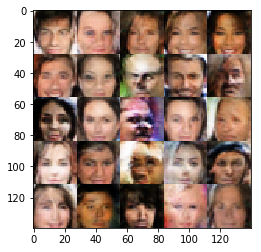

Epoch 1/1... Discriminator Loss: 1.2785... Generator Loss: 0.7915
Epoch 1/1... Discriminator Loss: 1.3177... Generator Loss: 0.6205
Epoch 1/1... Discriminator Loss: 1.3484... Generator Loss: 0.7011


In [14]:
batch_size = 64
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5

visualise = {'d_loss':[], 'g_loss':[]}

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

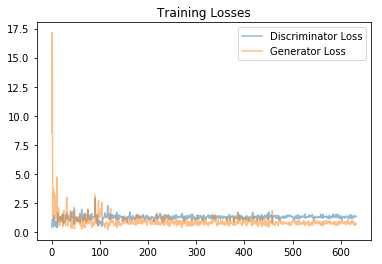

In [15]:
pyplot.plot(visualise['d_loss'], label='Discriminator Loss', alpha=0.5)
pyplot.plot(visualise['g_loss'], label='Generator Loss', alpha=0.5)
pyplot.legend()

pyplot.title("Training Losses")

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.